In [104]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
from preference_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio

In [2]:
def unravel_index(index, shape):
    out = []
    for dim in reversed(shape):
        out.append(index % dim)
        index = index // dim
    return reversed(out)

In [105]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=3, p=5, learning_rate=3e-4, dummy_reward=False):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        #for param in self.PPnet.features.parameters():
        #    param.requires_grad = True
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = torch.nn.DataParallel(self.PPnet)
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = True
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = True
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = True
        #self.critic_model = self.construct_critic().cuda()
        self.p = p
        self.critic_model = Critic().cuda()
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  {'params': self.PPnet.add_on_layers.parameters(), 'lr': 3e-3, 'weight_decay': 0},
                                  {'params': self.PPnet.prototype_vectors, 'lr': 3e-6}
            
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        #self.policy_optimizer = torch.optim.Adam(self.PPnet.features.parameters())
        self.critic_optimizer = torch.optim.Adam(self.critic_model.parameters())
        self.num_iteration = 0
        
    def get_heatmaps(self, batch_x, labels, dummy=False):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        #for param in self.PPnet_multi.parameters():
        #    if param.requires_grad == True:
        #        print(param.grad)
        #print(proto_dist_torch.grad)
        #proto_dist_ = np.copy(proto_dist_torch.detach().cpu().numpy())
        #print(proto_dist_torch.grad_fn)
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        distances = torch.amin(proto_dist_, axis=-1)
        #distances = torch.tensor(distances)
        #print("Distances grad: ", distances.grad)
        actions = self.sample_from_distances(distances, labels)
        proto_dist = torch.clone(proto_dist_torch)
        # Move to cpu and cast to numpy here
        # proto_dist shape: (1000, 80, 7, 7)
        proto_dist = torch.transpose(proto_dist, 0, 1)
        proto_dist = proto_dist.detach().cpu().numpy()
        heatmaps = []
        joint_log_probs = []
        r = []
        for action in actions:
            img_idx, probs, j, class_identity = action[0], action[1], action[2], action[3]
            heatmaps_j = []
            r_j = []
            for i in img_idx:
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist[j][i],axis=None), proto_dist[j][i].shape))
                #print(closest_patch_indices_in_distance_map_j)
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                #print(closest_patch_indices_in_distance_map_j)
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist[j][i] + 1)/(proto_dist[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                #print(j)
                #if j in [0, 1, 2, 3, 4]:
                #    print(patch_indices)
                img_size = original_img.shape[0]
                
                # dummy 1: centralize
                score = img_size * 2 - np.absolute(img_size//2 - patch_indices[0]) - np.absolute(img_size//2 - patch_indices[1]) - np.absolute(img_size//2 - patch_indices[2]) - np.absolute(img_size//2 - patch_indices[3])
                #score = -(patch_indices[1] - patch_indices[0]) * (patch_indices[3] - patch_indices[2])
            
                # dummy 2: maximize area of heatmap
                #score = (patch_indices[1]-patch_indices[0]) * (patch_indices[3] - patch_indices[2])
                
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
                heatmap = np.float32(heatmap) / 255
                heatmap = heatmap[..., ::-1]
                overlayed_original_img = 0.5 * original_img + 1.0 * heatmap
                overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
                overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
                if dummy:
                    heatmaps_j.append(overlayed_original_img)
                    r_j.append(score)
                else:
                    heatmaps_j.append(overlayed_original_img)
            joint_log_prob = torch.prod(probs) * math.factorial(self.k)
            #print(joint_log_prob.grad_fn)
            heatmaps.append(heatmaps_j)
            if dummy:
                r.append(r_j)
            joint_log_probs.append(joint_log_prob)
                
        # num_prototypes * self.k heatmaps in total
        # num_prototypes probs
        #for prob in joint_log_probs:
        #    print(prob.grad_fn)
        if dummy:
            r = np.sum(np.array(r), axis=1)
            r = torch.tensor(r)
            return heatmaps, joint_log_probs, distances, r
        return heatmaps, joint_log_probs, distances
    
    def sample_from_distances(self, distances, labels):
        '''
        Takes in distances of shape (80, 1000)
        returns actions of shape (1000, ), one for each prototype
        '''
        distances = torch.clip(distances, min=1e-7, max=None)
        similarities = 1 / distances
        softmax_dist = F.softmax(similarities, dim=0)
        softmax_dist = torch.transpose(softmax_dist, 0, 1)
        # Maybe using combinatorics?
        actions = []
        for i in range(softmax_dist.shape[0]):
            class_identity = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])
            #print("Class identity: ", class_identity)
            class_dist = softmax_dist[i][labels==class_identity]
            #print("Class dist shape:", class_dist.shape)
            if len(class_dist) > self.k:
                dist = Categorical(class_dist)
                img_idx = dist.sample(sample_shape=torch.tensor([self.k]))
                probs = dist.log_prob(img_idx)
                probs = torch.exp(probs)
                actions.append([img_idx, probs, i, class_identity])
        return actions
    
    def construct_critic(self):
        critic_model = nn.Sequential(
                        nn.Linear(512 * self.k * 7 * 7, 120),
                        nn.Sigmoid(),
                        nn.Linear(120, 20),
                        nn.Sigmoid(),
                        nn.Linear(20, 1)
                        )
        return critic_model
    
    # Currently just the same architecture as the pref_net
    '''
    def critic(self, heatmaps):
        values = torch.empty(len(heatmaps))
        for i in tqdm(range(len(heatmaps))):
            #x = torch.tensor(heatmaps[i])
            x = np.concatenate(heatmaps[i], axis=1)
            x = torch.tensor(x).cuda()
            x = torch.unsqueeze(x, axis=0)
            x = torch.transpose(x, 1, 3)
            with torch.no_grad():
                x = self.pf_model.conv_features(x)
                x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = self.critic_model(x)
            values[i] = x
            #print(i)
        return values
    '''
    
    # Need to vectorize
    def get_critic_inputs(self, heatmaps, dummy=False):
        critic_inputs = []
        for i in range(len(heatmaps)):
            x = np.concatenate(heatmaps[i], axis=1)
            x = torch.tensor(x).cuda()
            x = torch.unsqueeze(x, axis=0)
            x = torch.transpose(x, 1, 3)
            with torch.no_grad():
                x = self.pf_model.conv_features(x)
                x = torch.flatten(x, 1) # flatten all dimensions except batch
            critic_inputs.append(x)
        critic_inputs = torch.stack(critic_inputs, dim=0)
        critic_inputs = critic_inputs.view(critic_inputs.shape[0], -1)
        #print(critic_inputs.shape)
        return critic_inputs
        
    def get_rewards(self, heatmaps, dummy=False):
        if dummy:
            h = heatmaps
            rewards = np.empty(len(h))
            for i in range(len(h)):
                score = -np.sum(np.square(h[i][0]-h[i][1])) - np.sum(np.square(h[i][1]-h[i][2])) - np.sum(np.square(h[i][0]-h[i][2]))
            rewards[i] = score
            return torch.tensor(rewards)
        with torch.no_grad():
            rewards = torch.empty(len(heatmaps))
            for i in range(len(heatmaps)):
                pf_input = torch.tensor(heatmaps[i]).cuda()
                pf_input = pf_input.view(pf_input.shape[0]*pf_input.shape[1], pf_input.shape[2], pf_input.shape[3])
                pf_input = torch.transpose(pf_input, 0, 2)
                pf_input = torch.transpose(pf_input, 1, 2)
                pf_input = torch.unsqueeze(pf_input, axis=0)
                reward = self.pf_model(pf_input)
                rewards[i] = reward
                #print(i)
        return rewards
        
    def update_v1(self, rewards, values, probs):
        self.policy_optimizer.zero_grad()
        for prob in probs:
            prob = prob.cuda()
        rewards = rewards.cuda()
        values = values.cuda()
        #print(list(self.PPnet_multi.module.features.parameters())[0])
        policy_loss = 0
        for i in range(len(rewards)):
            policy_loss -= probs[i] * (rewards[i] - values[i])    
        policy_loss.backward(retain_graph=True)
        self.policy_optimizer.step()
        #print(list(self.PPnet_multi.module.features.parameters())[0])
        self.critic_optimizer.zero_grad()
        #print(list(self.critic_model.parameters())[0])
        critic_loss = 0
        for i in range(len(rewards)):
            critic_loss += (rewards[i] - values[i]) ** 2
        #print(critic_loss.grad_fn)
        critic_loss.backward()
        self.critic_optimizer.step()
        #print(list(self.critic_model.parameters())[0])
        
        return 
    
    def update_v2(self, rewards, values, probs):
        
        return
    
    
    def run(self, batch_x, labels, save_prototypes=[], save_iters=[]):

        # action is n_prototypes * k heatmaps
        heatmaps, probs, img_distances = self.get_heatmaps(batch_x, labels)
        #print("Finished calculating heatmaps")
        critic_inputs = self.get_critic_inputs(heatmaps)
        #print("Finished getting critic inputs")
        values = self.critic_model(critic_inputs)
        #print("Finished calculating values")
        rewards = self.get_rewards(heatmaps)
        #print("Finished calculating rewards")
        self.update_v1(rewards, values, probs)
        #print("Finished updating. Done.")
        if len(save_prototypes) > 0 and self.num_iteration in save_iters:
            for p in save_prototypes:
                for k in range(len(heatmaps[p])):
                    plt.imsave(r'./A3C_results/iter_'+str(self.num_iteration)+'_prototype_'+str(p)+'_best_'+str(k+1)+'.jpg', heatmaps[p][k])
        self.num_iteration += 1
        
        return rewards, values, probs
    
    def run_dummy(self, batch_x, labels, save_prototypes=[], save_iters=[]):
        heatmaps, probs, img_distances, rewards  = self.get_heatmaps(batch_x, labels, dummy=True)
        print("rewards for first 5: ", rewards[:5])
        critic_inputs = self.get_critic_inputs(heatmaps)
        values = self.critic_model(critic_inputs)
        self.update_v1(rewards, values, probs)
        if len(save_prototypes) > 0 and self.num_iteration in save_iters:
            for p in save_prototypes:
                for k in range(len(heatmaps[p])):
                    plt.imsave(r'./A3C_results/iter_'+str(self.num_iteration)+'_prototype_'+str(p)+'_best_'+str(k+1)+'_dummy.jpg', heatmaps[p][k])
        self.num_iteration += 1
        
        
        return rewards, values, probs, heatmaps

In [106]:
class Critic(nn.Module):
    def __init__(self, k=3, learning_rate=3e-4):
        super(Critic, self).__init__()
        
        '''
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
        '''
        
        self.k = k
        self.fc1 = nn.Linear(512 * k * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, 1)
        
    
    def forward(self, x):

        out = torch.sigmoid(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        out = self.fc3(out)

        return out

In [107]:
ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')

pf_model = construct_PrefNet("resnet18")
pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))
#pf_model = torch.load(r'./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')

<All keys matched successfully>

In [108]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))
dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=False,
    num_workers=2, pin_memory=False)

In [75]:
a3c = A3C_PPnet(ppnet, pf_model)

In [76]:
prob_records = np.empty((50, 1000))
reward_records = np.empty((50, 1000))
data_iter = iter(dataloader)
for _ in range(30):
    batch, labels = next(data_iter)
for i in tqdm(range(50)):
    rewards, values, probs = a3c.run(batch, labels, save_prototypes=[], save_iters=[])
    print(len(probs))
    total_reward = 0
    mse_loss = 0
    for j in range(len(probs)):
        #probs[j] = probs[j].detach().cpu().numpy()
        #rewards[j] = rewards[j].detach().cpu().numpy()
        total_reward += probs[j] * rewards[j]
        mse_loss += (rewards[j] - values[j]) ** 2
        prob_records[i][j] = probs[j].detach().cpu().numpy()
        reward_records[i][j] = rewards[j].detach().cpu().numpy()
    print("Iteration "+str(i)+" total expected reward: ", total_reward)
    print("Iteration "+str(i)+" total mse loss: ", mse_loss)

  2%|▏         | 1/50 [00:05<04:08,  5.06s/it]

20
Iteration 0 total expected reward:  tensor(14.4962, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 0 total mse loss:  tensor([153.0895], device='cuda:0', grad_fn=<AddBackward0>)


  4%|▍         | 2/50 [00:09<03:39,  4.58s/it]

20
Iteration 1 total expected reward:  tensor(136.4804, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 1 total mse loss:  tensor([132.7958], device='cuda:0', grad_fn=<AddBackward0>)


  6%|▌         | 3/50 [00:13<03:24,  4.36s/it]

20
Iteration 2 total expected reward:  tensor(160.2773, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 2 total mse loss:  tensor([121.9269], device='cuda:0', grad_fn=<AddBackward0>)


  8%|▊         | 4/50 [00:17<03:17,  4.30s/it]

20
Iteration 3 total expected reward:  tensor(114.4014, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 3 total mse loss:  tensor([120.7933], device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 5/50 [00:21<03:09,  4.22s/it]

20
Iteration 4 total expected reward:  tensor(89.9006, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 4 total mse loss:  tensor([111.6918], device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 6/50 [00:25<03:04,  4.19s/it]

20
Iteration 5 total expected reward:  tensor(145.5687, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 5 total mse loss:  tensor([110.3859], device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 7/50 [00:30<03:00,  4.20s/it]

20
Iteration 6 total expected reward:  tensor(130.4091, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 6 total mse loss:  tensor([106.8802], device='cuda:0', grad_fn=<AddBackward0>)


 16%|█▌        | 8/50 [00:34<02:54,  4.16s/it]

20
Iteration 7 total expected reward:  tensor(113.3556, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 7 total mse loss:  tensor([98.0774], device='cuda:0', grad_fn=<AddBackward0>)


 18%|█▊        | 9/50 [00:38<02:51,  4.17s/it]

20
Iteration 8 total expected reward:  tensor(129.1423, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 8 total mse loss:  tensor([105.7258], device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 10/50 [00:42<02:45,  4.15s/it]

20
Iteration 9 total expected reward:  tensor(215.2790, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 9 total mse loss:  tensor([83.7077], device='cuda:0', grad_fn=<AddBackward0>)


 22%|██▏       | 11/50 [00:46<02:41,  4.13s/it]

20
Iteration 10 total expected reward:  tensor(122.0967, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 10 total mse loss:  tensor([84.4714], device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 12/50 [00:50<02:37,  4.15s/it]

20
Iteration 11 total expected reward:  tensor(131.0689, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 11 total mse loss:  tensor([100.2237], device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 13/50 [00:54<02:33,  4.16s/it]

20
Iteration 12 total expected reward:  tensor(185.9126, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 12 total mse loss:  tensor([65.5085], device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 14/50 [00:59<02:29,  4.16s/it]

20
Iteration 13 total expected reward:  tensor(177.3540, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 13 total mse loss:  tensor([80.8562], device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 15/50 [01:03<02:25,  4.14s/it]

20
Iteration 14 total expected reward:  tensor(217.8541, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 14 total mse loss:  tensor([82.9509], device='cuda:0', grad_fn=<AddBackward0>)


 32%|███▏      | 16/50 [01:07<02:20,  4.14s/it]

20
Iteration 15 total expected reward:  tensor(216.1223, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 15 total mse loss:  tensor([60.6302], device='cuda:0', grad_fn=<AddBackward0>)


 34%|███▍      | 17/50 [01:11<02:16,  4.14s/it]

20
Iteration 16 total expected reward:  tensor(188.5930, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 16 total mse loss:  tensor([53.4164], device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 18/50 [01:15<02:12,  4.14s/it]

20
Iteration 17 total expected reward:  tensor(184.8374, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 17 total mse loss:  tensor([57.9811], device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 19/50 [01:19<02:08,  4.16s/it]

20
Iteration 18 total expected reward:  tensor(176.2450, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 18 total mse loss:  tensor([58.5729], device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 20/50 [01:23<02:04,  4.14s/it]

20
Iteration 19 total expected reward:  tensor(195.0896, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 19 total mse loss:  tensor([65.5524], device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 21/50 [01:27<01:59,  4.12s/it]

20
Iteration 20 total expected reward:  tensor(170.0764, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 20 total mse loss:  tensor([71.4034], device='cuda:0', grad_fn=<AddBackward0>)


 44%|████▍     | 22/50 [01:32<01:55,  4.14s/it]

20
Iteration 21 total expected reward:  tensor(208.6102, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 21 total mse loss:  tensor([62.2877], device='cuda:0', grad_fn=<AddBackward0>)


 46%|████▌     | 23/50 [01:36<01:51,  4.14s/it]

20
Iteration 22 total expected reward:  tensor(237.0596, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 22 total mse loss:  tensor([51.0224], device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 24/50 [01:40<01:48,  4.16s/it]

20
Iteration 23 total expected reward:  tensor(246.5971, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 23 total mse loss:  tensor([52.0245], device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 25/50 [01:44<01:44,  4.16s/it]

20
Iteration 24 total expected reward:  tensor(226.8640, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 24 total mse loss:  tensor([59.2018], device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 26/50 [01:48<01:39,  4.14s/it]

20
Iteration 25 total expected reward:  tensor(241.8626, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 25 total mse loss:  tensor([49.6085], device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 27/50 [01:52<01:34,  4.12s/it]

20
Iteration 26 total expected reward:  tensor(235.0959, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 26 total mse loss:  tensor([50.4958], device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 28/50 [01:56<01:31,  4.14s/it]

20
Iteration 27 total expected reward:  tensor(239.0053, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 27 total mse loss:  tensor([40.0786], device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████▊    | 29/50 [02:01<01:27,  4.14s/it]

20
Iteration 28 total expected reward:  tensor(230.9327, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 28 total mse loss:  tensor([39.2993], device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 30/50 [02:05<01:22,  4.13s/it]

20
Iteration 29 total expected reward:  tensor(245.5770, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 29 total mse loss:  tensor([38.1092], device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 31/50 [02:09<01:18,  4.13s/it]

20
Iteration 30 total expected reward:  tensor(245.1831, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 30 total mse loss:  tensor([50.0719], device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 32/50 [02:13<01:14,  4.11s/it]

20
Iteration 31 total expected reward:  tensor(250.2042, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 31 total mse loss:  tensor([39.3080], device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 33/50 [02:17<01:09,  4.11s/it]

20
Iteration 32 total expected reward:  tensor(249.5346, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 32 total mse loss:  tensor([47.2346], device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████▊   | 34/50 [02:21<01:06,  4.15s/it]

20
Iteration 33 total expected reward:  tensor(252.2323, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 33 total mse loss:  tensor([54.7665], device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 35/50 [02:25<01:02,  4.14s/it]

20
Iteration 34 total expected reward:  tensor(257.1210, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 34 total mse loss:  tensor([42.5904], device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████▏  | 36/50 [02:30<00:58,  4.15s/it]

20
Iteration 35 total expected reward:  tensor(240.6148, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 35 total mse loss:  tensor([43.5360], device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████▍  | 37/50 [02:34<00:53,  4.13s/it]

20
Iteration 36 total expected reward:  tensor(262.4570, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 36 total mse loss:  tensor([44.6139], device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 38/50 [02:38<00:49,  4.13s/it]

20
Iteration 37 total expected reward:  tensor(262.5303, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 37 total mse loss:  tensor([37.7771], device='cuda:0', grad_fn=<AddBackward0>)


 78%|███████▊  | 39/50 [02:42<00:45,  4.13s/it]

20
Iteration 38 total expected reward:  tensor(262.4197, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 38 total mse loss:  tensor([44.0545], device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 40/50 [02:46<00:41,  4.14s/it]

20
Iteration 39 total expected reward:  tensor(262.4037, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 39 total mse loss:  tensor([50.1697], device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 41/50 [02:50<00:37,  4.15s/it]

20
Iteration 40 total expected reward:  tensor(262.9215, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 40 total mse loss:  tensor([46.0135], device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 42/50 [02:54<00:33,  4.13s/it]

20
Iteration 41 total expected reward:  tensor(262.6508, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 41 total mse loss:  tensor([34.4108], device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 43/50 [02:58<00:28,  4.12s/it]

20
Iteration 42 total expected reward:  tensor(261.6345, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 42 total mse loss:  tensor([30.2872], device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 44/50 [03:03<00:24,  4.13s/it]

20
Iteration 43 total expected reward:  tensor(264.5014, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 43 total mse loss:  tensor([31.0152], device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 45/50 [03:07<00:20,  4.12s/it]

20
Iteration 44 total expected reward:  tensor(262.6739, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 44 total mse loss:  tensor([42.2621], device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 46/50 [03:11<00:16,  4.14s/it]

20
Iteration 45 total expected reward:  tensor(261.4925, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 45 total mse loss:  tensor([32.8354], device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████▍| 47/50 [03:15<00:12,  4.14s/it]

20
Iteration 46 total expected reward:  tensor(262.6529, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 46 total mse loss:  tensor([28.4363], device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████▌| 48/50 [03:19<00:08,  4.13s/it]

20
Iteration 47 total expected reward:  tensor(262.9033, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 47 total mse loss:  tensor([32.5904], device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 49/50 [03:23<00:04,  4.16s/it]

20
Iteration 48 total expected reward:  tensor(265.0981, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 48 total mse loss:  tensor([23.6719], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 50/50 [03:27<00:00,  4.16s/it]

20
Iteration 49 total expected reward:  tensor(263.4162, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 49 total mse loss:  tensor([24.9473], device='cuda:0', grad_fn=<AddBackward0>)


In [56]:
np.save(r'./A3C_results/prob_records_iter50_batch20.npy', prob_records)
np.save(r'./A3C_results/reward_records_iter50_batch20.npy', reward_records)

In [72]:
reward_records.shape

(50, 1000)

In [65]:
reward_records[:, 5:10]

array([[ 0.36433738,  0.4042348 ,  2.31094313,  0.42457137,  2.14943171],
       [ 1.66124415, -2.14522076,  2.69878578,  2.33691406,  2.46307659],
       [ 2.80756998,  2.65605068,  2.51402664,  2.94985819,  2.58756256],
       [ 2.78273773,  0.09197196,  2.86457443,  1.59659731,  2.9044714 ],
       [ 2.77105474,  0.33422118,  2.9085083 ,  2.94608498,  2.93435335],
       [ 2.73116016, -1.41355145,  2.9211297 ,  2.95566511,  2.94032574],
       [ 2.73702383,  2.85700798,  2.93294382,  2.94927549,  2.94230556],
       [ 2.74650431,  2.91679716,  2.93067646,  2.95252657,  2.93957472],
       [ 2.76628923, -0.06386983,  2.93366146,  2.93914938,  2.93751049],
       [ 2.82264709,  1.63762653,  2.92370129,  2.95402575,  2.92780828],
       [ 2.82395172,  2.94235086,  2.92168045, -1.77712715,  2.92276669],
       [ 2.88308287,  2.35129881,  2.92046642, -0.68057299,  2.92204809],
       [ 2.79308558,  2.95450306,  2.91784191,  2.95395184,  2.90852261],
       [ 2.84736538,  2.90539169,  2.9

In [64]:
prob_records[:, 5:10]

array([[5.96966314e+00, 8.39650165e-03, 5.99999809e+00, 2.11405363e-02,
        5.99636698e+00],
       [5.99994755e+00, 4.40450991e-03, 4.75500107e+00, 6.88742194e-03,
        5.99906540e+00],
       [5.99860430e+00, 3.16718034e-02, 5.99999809e+00, 3.27830464e-02,
        5.99999809e+00],
       [5.99930906e+00, 3.24300199e-04, 5.99999809e+00, 3.49299908e-02,
        5.99999809e+00],
       [5.99877357e+00, 1.52460905e-03, 5.99999809e+00, 1.55284340e-02,
        5.99999809e+00],
       [5.99970627e+00, 1.26627609e-04, 5.99999809e+00, 8.16874439e-04,
        5.99999142e+00],
       [5.99982405e+00, 2.55963439e-03, 5.99999809e+00, 1.64612923e-02,
        5.99999571e+00],
       [5.99995899e+00, 3.51681738e-05, 5.99999809e+00, 4.27028164e-04,
        5.99999809e+00],
       [5.99999142e+00, 1.00350837e-04, 5.99999809e+00, 6.93371519e-03,
        5.99999809e+00],
       [5.99999142e+00, 2.63947877e-05, 5.99999809e+00, 1.01117429e-03,
        5.99999809e+00],
       [5.99999046e+00, 5.7598

In [39]:
prob_records_sorted = np.sort(prob_records, axis=1)
sorted_prob_index = np.argsort(prob_records, axis=1)
print(sorted_prob_index.shape)

(10, 1000)


In [42]:
prob_records[0][sorted_prob_index[0][-100:]]

array([3.1546278 , 3.33953476, 3.35639477, 3.66883135, 3.70347977,
       3.7588191 , 3.83299041, 3.83299041, 3.88497162, 3.9135766 ,
       3.95696306, 4.15255356, 4.31025791, 4.33145142, 4.36347342,
       4.46746016, 4.61634111, 4.68425179, 4.71241188, 4.9184804 ,
       4.94390678, 4.95119905, 5.11668777, 5.30823374, 5.35067034,
       5.37403584, 5.37604761, 5.42540026, 5.46156883, 5.51010084,
       5.57676554, 5.58917475, 5.62009096, 5.63833141, 5.65631962,
       5.73786974, 5.74734545, 5.75679827, 5.7850008 , 5.84051895,
       5.84336281, 5.86585045, 5.86763573, 5.88327503, 5.89575529,
       5.9021287 , 5.92162323, 5.92976141, 5.93262672, 5.94436979,
       5.95309639, 5.96435022, 5.96940517, 5.98616838, 5.98733902,
       5.99058199, 5.99097824, 5.9921999 , 5.99560738, 5.99593163,
       5.99617386, 5.99622107, 5.9969244 , 5.99782753, 5.99933243,
       5.99948931, 5.99974155, 5.99978209, 5.99981308, 5.99985504,
       5.99987555, 5.99994183, 5.99994183, 5.9999485 , 5.99995

In [48]:
reward_records[0][sorted_prob_index[0][-100:]]

array([ 2.95592165, -2.82480574, -2.66942024, -2.87655592,  2.65273333,
        2.95444059, -2.83822775, -2.83822775,  2.95611429, -2.87763977,
       -2.55860901, -2.87759066,  1.05071831,  1.99227178, -2.63136625,
        2.9560895 ,  2.95625019,  1.81558704, -2.87426138,  2.95626116,
       -2.87668371,  2.95592642,  0.56000394,  2.95593262,  2.82985115,
       -2.87542105,  2.95610237, -2.7824192 ,  2.95625544,  2.95538521,
       -0.88582468,  1.78973567,  2.84648705, -0.49043298,  1.76294279,
        2.82052374, -2.86940479,  0.74559736,  2.929389  , -2.56735229,
        2.8025589 ,  2.95449209,  2.95450878,  1.80669439,  2.95627499,
        2.39929771, -2.87768412,  2.95241928,  1.55573928, -2.63089275,
        2.95429802, -2.86952496,  2.16030598,  2.95075798,  0.91464406,
        2.95511246,  2.95502377, -2.40150547,  2.77435732,  1.88581896,
        2.95567465,  2.95625257,  1.82907784, -2.84644365,  2.37964201,
        2.9548502 ,  2.93420267,  2.95518255,  1.77334046,  2.95

In [53]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3])

In [109]:
a3c_dummy_reward = A3C_PPnet(ppnet, pf_model)

In [110]:

prob_records_dummy = np.empty((50, 1000))
reward_records_dummy = np.empty((50, 1000))
h_records = []
data_iter = iter(dataloader)
for _ in range(20):
    batch, label = next(data_iter)
for i in tqdm(range(50)):
    rewards, values, probs, h = a3c_dummy_reward.run_dummy(batch, label, save_prototypes=[0, 1, 2, 3, 4], save_iters=[0, 10, 20, 30, 40, 49])
    total_reward = 0
    mse_loss = 0
    
    #h_records.append(h)
    for j in range(len(probs)):
        #probs[j] = probs[j].detach().cpu().numpy()
        #rewards[j] = rewards[j].detach().cpu().numpy()
        total_reward += probs[j] * rewards[j]
        mse_loss += (rewards[j] - values[j]) ** 2
        prob_records_dummy[i][j] = probs[j].detach().cpu().numpy()
        reward_records_dummy[i][j] = rewards[j].detach().cpu().numpy()
    print("Iteration "+str(i)+" total expected reward: ", total_reward)
    print("Iteration "+str(i)+" total mse loss: ", mse_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

rewards for first 5:  tensor([143808, 103148,  81900,  67500, 143908])


  2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

Iteration 0 total expected reward:  tensor(8629267., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 0 total mse loss:  tensor([2.6831e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 116844,  67500,  81900, 116844])


  4%|▍         | 2/50 [00:02<00:51,  1.06s/it]

Iteration 1 total expected reward:  tensor(12348591., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 1 total mse loss:  tensor([2.5681e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 122304,  99372,  99372, 137388])


  6%|▌         | 3/50 [00:02<00:43,  1.09it/s]

Iteration 2 total expected reward:  tensor(10802541., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 2 total mse loss:  tensor([2.8438e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 122304,  99372,  99372, 137388])


  8%|▊         | 4/50 [00:03<00:38,  1.18it/s]

Iteration 3 total expected reward:  tensor(10730118., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 3 total mse loss:  tensor([2.6180e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 122304, 116844,  99372, 143808])


 10%|█         | 5/50 [00:04<00:36,  1.24it/s]

Iteration 4 total expected reward:  tensor(11609986., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 4 total mse loss:  tensor([2.7302e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 118664, 116844, 111020, 143808])


 12%|█▏        | 6/50 [00:05<00:34,  1.27it/s]

Iteration 5 total expected reward:  tensor(10083715., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 5 total mse loss:  tensor([2.6824e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 116844, 116844, 116844, 143808])


 14%|█▍        | 7/50 [00:05<00:33,  1.30it/s]

Iteration 6 total expected reward:  tensor(12252965., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 6 total mse loss:  tensor([2.8304e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 116844, 116844, 116844, 141668])


 16%|█▌        | 8/50 [00:06<00:32,  1.30it/s]

Iteration 7 total expected reward:  tensor(8748370., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 7 total mse loss:  tensor([2.6567e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 125832, 116844, 116844, 128996])


 18%|█▊        | 9/50 [00:07<00:31,  1.31it/s]

Iteration 8 total expected reward:  tensor(8506256., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 8 total mse loss:  tensor([2.6684e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 125832, 116844, 116844,  99372])


 20%|██        | 10/50 [00:08<00:30,  1.32it/s]

Iteration 9 total expected reward:  tensor(8031084., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 9 total mse loss:  tensor([2.5599e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 111020, 116844, 116844,  99372])


 22%|██▏       | 11/50 [00:08<00:29,  1.33it/s]

Iteration 10 total expected reward:  tensor(8611160., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 10 total mse loss:  tensor([2.5690e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 125832, 116844, 116844,  99372])


 24%|██▍       | 12/50 [00:09<00:28,  1.34it/s]

Iteration 11 total expected reward:  tensor(9383588., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 11 total mse loss:  tensor([2.5666e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 105196, 116844, 116844,  99372])


 26%|██▌       | 13/50 [00:10<00:27,  1.34it/s]

Iteration 12 total expected reward:  tensor(9621004., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 12 total mse loss:  tensor([2.5179e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 28%|██▊       | 14/50 [00:11<00:26,  1.34it/s]

Iteration 13 total expected reward:  tensor(9651740., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 13 total mse loss:  tensor([2.5252e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 114184, 116844, 116844,  99372])


 30%|███       | 15/50 [00:11<00:26,  1.34it/s]

Iteration 14 total expected reward:  tensor(11231881., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 14 total mse loss:  tensor([2.5525e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 113160, 116844, 116844,  99372])


 32%|███▏      | 16/50 [00:12<00:26,  1.30it/s]

Iteration 15 total expected reward:  tensor(11297504., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 15 total mse loss:  tensor([2.5597e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808, 128996, 116844, 116844,  99372])


 34%|███▍      | 17/50 [00:13<00:25,  1.32it/s]

Iteration 16 total expected reward:  tensor(11546472., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 16 total mse loss:  tensor([2.6101e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 36%|███▌      | 18/50 [00:14<00:24,  1.33it/s]

Iteration 17 total expected reward:  tensor(11249806., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 17 total mse loss:  tensor([2.5427e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 38%|███▊      | 19/50 [00:14<00:23,  1.33it/s]

Iteration 18 total expected reward:  tensor(11813109., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 18 total mse loss:  tensor([2.6078e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 40%|████      | 20/50 [00:15<00:22,  1.34it/s]

Iteration 19 total expected reward:  tensor(12062977., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 19 total mse loss:  tensor([2.4529e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 42%|████▏     | 21/50 [00:16<00:21,  1.34it/s]

Iteration 20 total expected reward:  tensor(12703467., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 20 total mse loss:  tensor([2.7085e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 44%|████▍     | 22/50 [00:17<00:20,  1.33it/s]

Iteration 21 total expected reward:  tensor(12935955., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 21 total mse loss:  tensor([2.8275e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 46%|████▌     | 23/50 [00:17<00:20,  1.33it/s]

Iteration 22 total expected reward:  tensor(13096127., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 22 total mse loss:  tensor([2.9499e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 48%|████▊     | 24/50 [00:18<00:19,  1.34it/s]

Iteration 23 total expected reward:  tensor(12549877., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 23 total mse loss:  tensor([2.9028e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 50%|█████     | 25/50 [00:19<00:18,  1.34it/s]

Iteration 24 total expected reward:  tensor(12961306., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 24 total mse loss:  tensor([3.1514e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 52%|█████▏    | 26/50 [00:20<00:17,  1.34it/s]

Iteration 25 total expected reward:  tensor(12912531., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 25 total mse loss:  tensor([3.0566e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 54%|█████▍    | 27/50 [00:20<00:17,  1.34it/s]

Iteration 26 total expected reward:  tensor(13517833., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 26 total mse loss:  tensor([3.1856e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 56%|█████▌    | 28/50 [00:21<00:16,  1.33it/s]

Iteration 27 total expected reward:  tensor(12727684., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 27 total mse loss:  tensor([3.0258e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 58%|█████▊    | 29/50 [00:22<00:15,  1.32it/s]

Iteration 28 total expected reward:  tensor(13489593., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 28 total mse loss:  tensor([3.0457e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 60%|██████    | 30/50 [00:23<00:15,  1.32it/s]

Iteration 29 total expected reward:  tensor(13556591., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 29 total mse loss:  tensor([3.0486e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 62%|██████▏   | 31/50 [00:23<00:14,  1.33it/s]

Iteration 30 total expected reward:  tensor(13556946., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 30 total mse loss:  tensor([3.0233e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 64%|██████▍   | 32/50 [00:24<00:13,  1.34it/s]

Iteration 31 total expected reward:  tensor(13556457., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 31 total mse loss:  tensor([3.0822e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 66%|██████▌   | 33/50 [00:25<00:12,  1.34it/s]

Iteration 32 total expected reward:  tensor(13556885., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 32 total mse loss:  tensor([3.1681e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 68%|██████▊   | 34/50 [00:26<00:11,  1.34it/s]

Iteration 33 total expected reward:  tensor(13556870., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 33 total mse loss:  tensor([3.0845e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 70%|███████   | 35/50 [00:26<00:11,  1.33it/s]

Iteration 34 total expected reward:  tensor(13556496., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 34 total mse loss:  tensor([3.0566e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 72%|███████▏  | 36/50 [00:27<00:10,  1.32it/s]

Iteration 35 total expected reward:  tensor(13552288., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 35 total mse loss:  tensor([3.0726e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 74%|███████▍  | 37/50 [00:28<00:09,  1.33it/s]

Iteration 36 total expected reward:  tensor(13431343., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 36 total mse loss:  tensor([3.0730e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 76%|███████▌  | 38/50 [00:29<00:08,  1.34it/s]

Iteration 37 total expected reward:  tensor(13395316., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 37 total mse loss:  tensor([2.9630e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 78%|███████▊  | 39/50 [00:29<00:08,  1.34it/s]

Iteration 38 total expected reward:  tensor(13398175., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 38 total mse loss:  tensor([3.0299e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 80%|████████  | 40/50 [00:30<00:07,  1.34it/s]

Iteration 39 total expected reward:  tensor(13389260., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 39 total mse loss:  tensor([2.9952e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 82%|████████▏ | 41/50 [00:31<00:06,  1.34it/s]

Iteration 40 total expected reward:  tensor(13393457., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 40 total mse loss:  tensor([3.0386e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 84%|████████▍ | 42/50 [00:32<00:06,  1.33it/s]

Iteration 41 total expected reward:  tensor(13460146., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 41 total mse loss:  tensor([2.9892e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 86%|████████▌ | 43/50 [00:32<00:05,  1.31it/s]

Iteration 42 total expected reward:  tensor(13457646., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 42 total mse loss:  tensor([3.0663e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 88%|████████▊ | 44/50 [00:33<00:04,  1.32it/s]

Iteration 43 total expected reward:  tensor(13626292., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 43 total mse loss:  tensor([3.1251e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 90%|█████████ | 45/50 [00:34<00:03,  1.33it/s]

Iteration 44 total expected reward:  tensor(13629821., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 44 total mse loss:  tensor([3.0795e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 92%|█████████▏| 46/50 [00:35<00:02,  1.34it/s]

Iteration 45 total expected reward:  tensor(13631907., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 45 total mse loss:  tensor([3.0983e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 94%|█████████▍| 47/50 [00:35<00:02,  1.34it/s]

Iteration 46 total expected reward:  tensor(13632093., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 46 total mse loss:  tensor([3.1073e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 96%|█████████▌| 48/50 [00:36<00:01,  1.34it/s]

Iteration 47 total expected reward:  tensor(13633831., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 47 total mse loss:  tensor([3.0926e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


 98%|█████████▊| 49/50 [00:37<00:00,  1.34it/s]

Iteration 48 total expected reward:  tensor(13633079., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 48 total mse loss:  tensor([3.0817e+11], device='cuda:0', grad_fn=<AddBackward0>)
rewards for first 5:  tensor([143808,  99372, 116844, 116844,  99372])


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

Iteration 49 total expected reward:  tensor(13633577., device='cuda:0', grad_fn=<AddBackward0>)
Iteration 49 total mse loss:  tensor([3.0907e+11], device='cuda:0', grad_fn=<AddBackward0>)


In [111]:
prob_records_dummy[:, :5]

array([[5.99999809e+00, 2.22222179e-01, 5.99999809e+00, 5.99999809e+00,
        4.80000004e-02],
       [5.82226419e+00, 5.99999809e+00, 5.99772263e+00, 5.99997234e+00,
        5.99999809e+00],
       [5.99999809e+00, 4.48233187e-01, 5.99699831e+00, 5.99999809e+00,
        3.62515783e+00],
       [5.99999809e+00, 1.98068237e+00, 5.97796297e+00, 5.99999809e+00,
        5.41239500e+00],
       [5.99999809e+00, 4.75955868e+00, 5.99027538e+00, 5.99955177e+00,
        3.56442404e+00],
       [5.99999475e+00, 5.65501809e-01, 5.99547863e+00, 2.60850489e-01,
        5.94449711e+00],
       [5.91896677e+00, 5.99152946e+00, 5.98858356e+00, 5.97096014e+00,
        5.88554859e+00],
       [3.58359098e+00, 1.62073404e-01, 5.08744431e+00, 3.32133079e+00,
        2.74835974e-01],
       [3.54165649e+00, 1.30809039e-01, 5.43934250e+00, 5.98802805e+00,
        7.27219343e-01],
       [2.90258788e-03, 1.95108801e-01, 5.60641909e+00, 5.99906635e+00,
        2.08667183e+00],
       [5.72000980e+00, 1.2275

In [112]:
reward_records_dummy[:, :5]

array([[143808., 103148.,  81900.,  67500., 143908.],
       [143808., 116844.,  67500.,  81900., 116844.],
       [143808., 122304.,  99372.,  99372., 137388.],
       [143808., 122304.,  99372.,  99372., 137388.],
       [143808., 122304., 116844.,  99372., 143808.],
       [143808., 118664., 116844., 111020., 143808.],
       [143808., 116844., 116844., 116844., 143808.],
       [143808., 116844., 116844., 116844., 141668.],
       [143808., 125832., 116844., 116844., 128996.],
       [143808., 125832., 116844., 116844.,  99372.],
       [143808., 111020., 116844., 116844.,  99372.],
       [143808., 125832., 116844., 116844.,  99372.],
       [143808., 105196., 116844., 116844.,  99372.],
       [143808.,  99372., 116844., 116844.,  99372.],
       [143808., 114184., 116844., 116844.,  99372.],
       [143808., 113160., 116844., 116844.,  99372.],
       [143808., 128996., 116844., 116844.,  99372.],
       [143808.,  99372., 116844., 116844.,  99372.],
       [143808.,  99372., 11

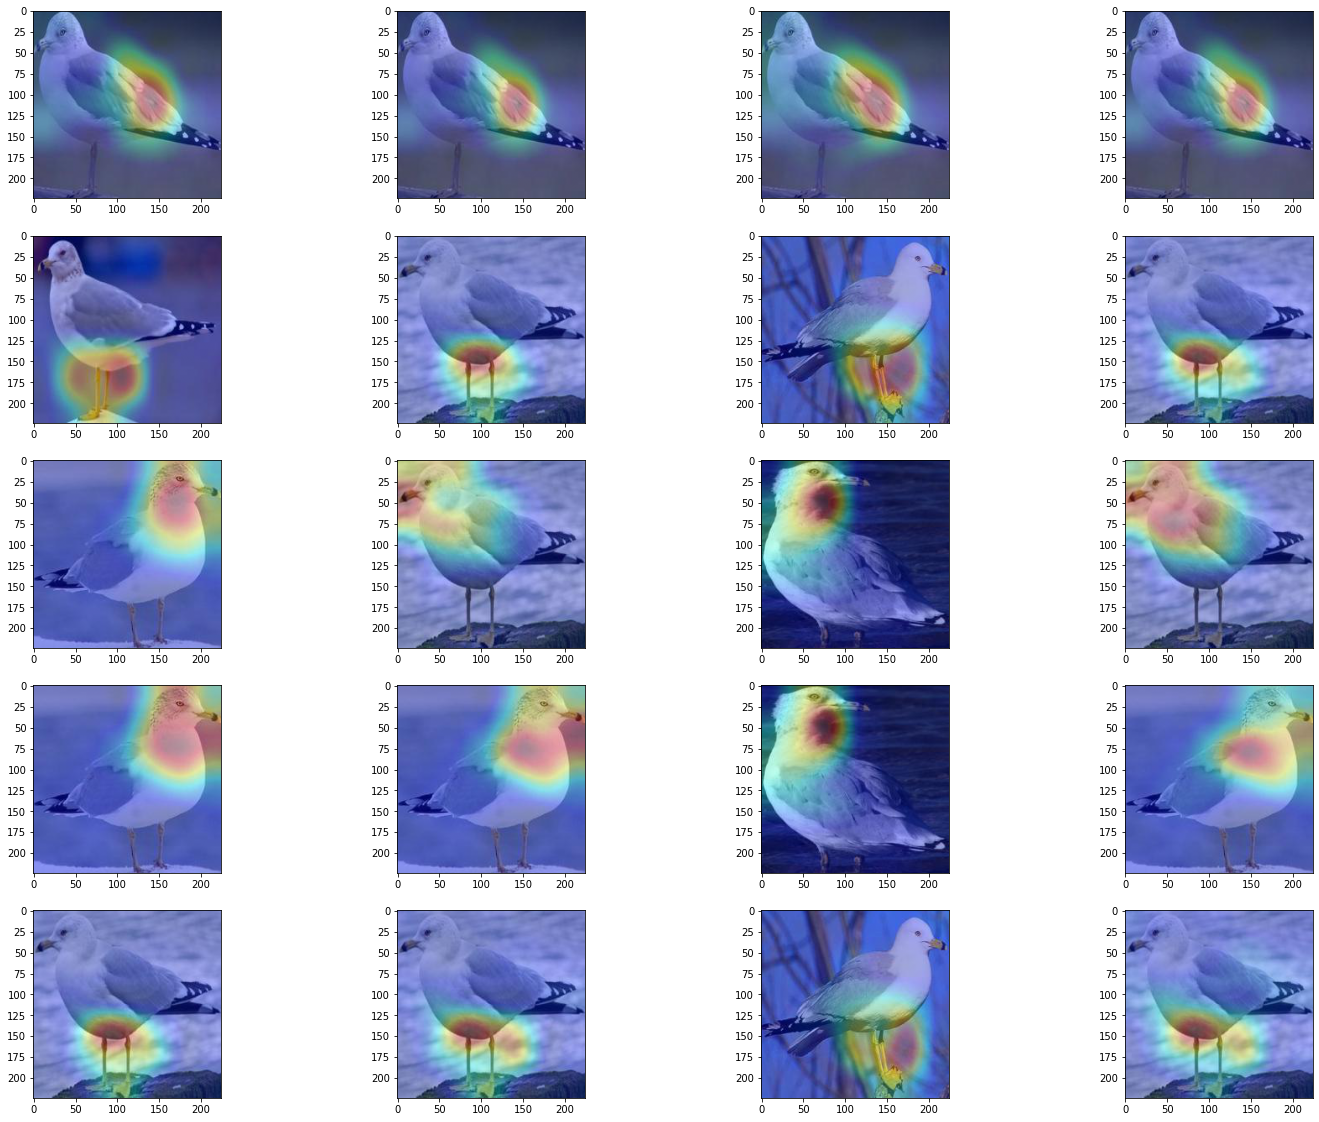

In [113]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for i in range(5):
    for j in range(4):
        im = skio.imread('./A3C_results/iter_'+str(j*3+4)+'_prototype_'+str(i)+'_best_1_dummy.jpg')
        im = sk.img_as_float(im)
        axes[i][j].imshow(im)

In [23]:
np.save(r'./A3C_results/prob_records_iter10_batch20_dummy.npy', prob_records_dummy)
np.save(r'./A3C_results/reward_records_iter10_batch20_dummy.npy', reward_records_dummy)

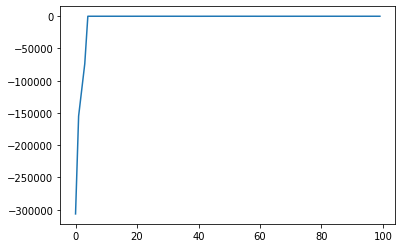

In [27]:
expected_rewards = []
for i in range(100):
    expected_reward = 0
    for j in range(1000):
        expected_reward += prob_records_dummy[i][j] * reward_records_dummy[i][j]
    expected_rewards.append(expected_reward)
plt.plot(np.arange(100), expected_rewards)
np.save(r'./A3C_results/expected_rewards_iter10_batch20_dummy.npy', expected_rewards)

(10, 1000)


In [ ]:
'''
reward_results = np.empty((50, 60))
value_loss_results = np.empty((50, 60))
for epoch in range(50):
    for i, (train_batch, label) in tqdm(enumerate(dataloader)):
    #for i in tqdm(range(100)):
        rewards, values, probs = a3c.run(train_batch)
        total_reward = 0
        mse_loss = 0
        for j in range(len(probs)):
            total_reward += probs[j] * rewards[j]
            mse_loss += (rewards[j] - values[j]) ** 2

        print("Epoch "+ str(epoch)+" Batch "+str(i)+" total expected reward: ", total_reward)
        print("Batch "+str(i)+" total mse loss: ", mse_loss)
        reward_results[epoch][i] = total_reward.detach().cpu().numpy()
        value_loss_results[epoch][i] = mse_loss.detach().cpu().numpy()
        #if i%10 == 0:
        #    torch.save(a3c.PPnet_multi, '../saved_models/iteration_'+str(i)+'_ppnet_multi_'+str(total_reward))
        #    torch.save(a3c.critic_model, '../saved_models/iteration_'+str(i)+'_critic_model_'+str(mse_loss))
        del train_batch
        for prob in probs:
            del prob
        del values
        del rewards
    avg_reward = np.mean(reward_results[epoch])
    torch.save(a3c.PPnet_multi, '../saved_models/ep_'+str(epoch)+'_ppnet_multi_'+str(avg_reward))
    torch.save(a3c.critic_model, '../saved_models/ep_'+str(epoch)+'_critic_model_'+str(avg_reward))
'''

1it [03:04, 184.88s/it]

Epoch 0 Batch 0 total expected reward:  tensor(1016.9069, device='cuda:0', grad_fn=<AddBackward0>)
Batch 0 total mse loss:  tensor([4916.5386], device='cuda:0', grad_fn=<AddBackward0>)


2it [06:13, 186.97s/it]

Epoch 0 Batch 1 total expected reward:  tensor(404.0566, device='cuda:0', grad_fn=<AddBackward0>)
Batch 1 total mse loss:  tensor([4228.8071], device='cuda:0', grad_fn=<AddBackward0>)


3it [09:24, 188.72s/it]

Epoch 0 Batch 2 total expected reward:  tensor(753.0262, device='cuda:0', grad_fn=<AddBackward0>)
Batch 2 total mse loss:  tensor([4006.8752], device='cuda:0', grad_fn=<AddBackward0>)


4it [12:33, 188.97s/it]

Epoch 0 Batch 3 total expected reward:  tensor(570.3600, device='cuda:0', grad_fn=<AddBackward0>)
Batch 3 total mse loss:  tensor([4125.3672], device='cuda:0', grad_fn=<AddBackward0>)


5it [15:37, 187.11s/it]

Epoch 0 Batch 4 total expected reward:  tensor(-85.6844, device='cuda:0', grad_fn=<AddBackward0>)
Batch 4 total mse loss:  tensor([5101.0708], device='cuda:0', grad_fn=<AddBackward0>)


6it [18:40, 185.69s/it]

Epoch 0 Batch 5 total expected reward:  tensor(243.7928, device='cuda:0', grad_fn=<AddBackward0>)
Batch 5 total mse loss:  tensor([4995.9551], device='cuda:0', grad_fn=<AddBackward0>)


7it [21:43, 184.84s/it]

Epoch 0 Batch 6 total expected reward:  tensor(218.7568, device='cuda:0', grad_fn=<AddBackward0>)
Batch 6 total mse loss:  tensor([3814.1658], device='cuda:0', grad_fn=<AddBackward0>)


8it [24:46, 184.36s/it]

Epoch 0 Batch 7 total expected reward:  tensor(180.2791, device='cuda:0', grad_fn=<AddBackward0>)
Batch 7 total mse loss:  tensor([3603.8333], device='cuda:0', grad_fn=<AddBackward0>)


9it [27:49, 183.86s/it]

Epoch 0 Batch 8 total expected reward:  tensor(228.3367, device='cuda:0', grad_fn=<AddBackward0>)
Batch 8 total mse loss:  tensor([3703.2227], device='cuda:0', grad_fn=<AddBackward0>)


10it [30:58, 185.38s/it]

Epoch 0 Batch 9 total expected reward:  tensor(19.4229, device='cuda:0', grad_fn=<AddBackward0>)
Batch 9 total mse loss:  tensor([4448.5674], device='cuda:0', grad_fn=<AddBackward0>)


11it [34:01, 184.67s/it]

Epoch 0 Batch 10 total expected reward:  tensor(84.8035, device='cuda:0', grad_fn=<AddBackward0>)
Batch 10 total mse loss:  tensor([4350.8662], device='cuda:0', grad_fn=<AddBackward0>)


12it [37:04, 184.19s/it]

Epoch 0 Batch 11 total expected reward:  tensor(43.6808, device='cuda:0', grad_fn=<AddBackward0>)
Batch 11 total mse loss:  tensor([4839.4316], device='cuda:0', grad_fn=<AddBackward0>)


13it [40:06, 183.72s/it]

Epoch 0 Batch 12 total expected reward:  tensor(86.5323, device='cuda:0', grad_fn=<AddBackward0>)
Batch 12 total mse loss:  tensor([4624.2812], device='cuda:0', grad_fn=<AddBackward0>)


14it [43:10, 183.56s/it]

Epoch 0 Batch 13 total expected reward:  tensor(82.4327, device='cuda:0', grad_fn=<AddBackward0>)
Batch 13 total mse loss:  tensor([3737.3894], device='cuda:0', grad_fn=<AddBackward0>)


15it [46:13, 183.39s/it]

Epoch 0 Batch 14 total expected reward:  tensor(2.5676, device='cuda:0', grad_fn=<AddBackward0>)
Batch 14 total mse loss:  tensor([5085.5103], device='cuda:0', grad_fn=<AddBackward0>)


16it [49:16, 183.27s/it]

Epoch 0 Batch 15 total expected reward:  tensor(1.1845, device='cuda:0', grad_fn=<AddBackward0>)
Batch 15 total mse loss:  tensor([4467.2900], device='cuda:0', grad_fn=<AddBackward0>)


17it [52:18, 183.08s/it]

Epoch 0 Batch 16 total expected reward:  tensor(-1.0540, device='cuda:0', grad_fn=<AddBackward0>)
Batch 16 total mse loss:  tensor([7315.7681], device='cuda:0', grad_fn=<AddBackward0>)


18it [55:21, 182.95s/it]

Epoch 0 Batch 17 total expected reward:  tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)
Batch 17 total mse loss:  tensor([6836.4512], device='cuda:0', grad_fn=<AddBackward0>)


19it [58:24, 183.04s/it]

Epoch 0 Batch 18 total expected reward:  tensor(-0.0040, device='cuda:0', grad_fn=<AddBackward0>)
Batch 18 total mse loss:  tensor([6357.5249], device='cuda:0', grad_fn=<AddBackward0>)


20it [1:01:27, 183.08s/it]

Epoch 0 Batch 19 total expected reward:  tensor(-0.0082, device='cuda:0', grad_fn=<AddBackward0>)
Batch 19 total mse loss:  tensor([7962.1641], device='cuda:0', grad_fn=<AddBackward0>)


21it [1:04:35, 184.35s/it]

Epoch 0 Batch 20 total expected reward:  tensor(-0.0143, device='cuda:0', grad_fn=<AddBackward0>)
Batch 20 total mse loss:  tensor([8594.5586], device='cuda:0', grad_fn=<AddBackward0>)


22it [1:07:38, 183.90s/it]

Epoch 0 Batch 21 total expected reward:  tensor(-0.0544, device='cuda:0', grad_fn=<AddBackward0>)
Batch 21 total mse loss:  tensor([7550.9956], device='cuda:0', grad_fn=<AddBackward0>)


23it [1:10:47, 185.57s/it]

Epoch 0 Batch 22 total expected reward:  tensor(-0.0122, device='cuda:0', grad_fn=<AddBackward0>)
Batch 22 total mse loss:  tensor([8897.7363], device='cuda:0', grad_fn=<AddBackward0>)


24it [1:13:50, 184.89s/it]

Epoch 0 Batch 23 total expected reward:  tensor(-0.0010, device='cuda:0', grad_fn=<AddBackward0>)
Batch 23 total mse loss:  tensor([4967.7935], device='cuda:0', grad_fn=<AddBackward0>)


25it [1:16:53, 184.26s/it]

Epoch 0 Batch 24 total expected reward:  tensor(-0.0069, device='cuda:0', grad_fn=<AddBackward0>)
Batch 24 total mse loss:  tensor([5089.6978], device='cuda:0', grad_fn=<AddBackward0>)


26it [1:19:56, 183.81s/it]

Epoch 0 Batch 25 total expected reward:  tensor(-0.0014, device='cuda:0', grad_fn=<AddBackward0>)
Batch 25 total mse loss:  tensor([4638.7930], device='cuda:0', grad_fn=<AddBackward0>)


27it [1:23:00, 183.89s/it]

Epoch 0 Batch 26 total expected reward:  tensor(0.0007, device='cuda:0', grad_fn=<AddBackward0>)
Batch 26 total mse loss:  tensor([5249.4731], device='cuda:0', grad_fn=<AddBackward0>)


28it [1:26:03, 183.74s/it]

Epoch 0 Batch 27 total expected reward:  tensor(-0.0275, device='cuda:0', grad_fn=<AddBackward0>)
Batch 27 total mse loss:  tensor([6061.5889], device='cuda:0', grad_fn=<AddBackward0>)


29it [1:29:07, 183.66s/it]

Epoch 0 Batch 28 total expected reward:  tensor(-0.0036, device='cuda:0', grad_fn=<AddBackward0>)
Batch 28 total mse loss:  tensor([5953.1812], device='cuda:0', grad_fn=<AddBackward0>)


30it [1:32:10, 183.56s/it]

Epoch 0 Batch 29 total expected reward:  tensor(-0.0053, device='cuda:0', grad_fn=<AddBackward0>)
Batch 29 total mse loss:  tensor([6268.8320], device='cuda:0', grad_fn=<AddBackward0>)


31it [1:35:14, 183.61s/it]

Epoch 0 Batch 30 total expected reward:  tensor(-0.0103, device='cuda:0', grad_fn=<AddBackward0>)
Batch 30 total mse loss:  tensor([7646.6675], device='cuda:0', grad_fn=<AddBackward0>)


32it [1:38:17, 183.58s/it]

Epoch 0 Batch 31 total expected reward:  tensor(-0.0043, device='cuda:0', grad_fn=<AddBackward0>)
Batch 31 total mse loss:  tensor([5503.0444], device='cuda:0', grad_fn=<AddBackward0>)


33it [1:41:20, 183.27s/it]

Epoch 0 Batch 32 total expected reward:  tensor(-0.0031, device='cuda:0', grad_fn=<AddBackward0>)
Batch 32 total mse loss:  tensor([5558.5527], device='cuda:0', grad_fn=<AddBackward0>)


34it [1:44:23, 183.36s/it]

Epoch 0 Batch 33 total expected reward:  tensor(-0.0088, device='cuda:0', grad_fn=<AddBackward0>)
Batch 33 total mse loss:  tensor([7085.7886], device='cuda:0', grad_fn=<AddBackward0>)


35it [1:47:27, 183.30s/it]

Epoch 0 Batch 34 total expected reward:  tensor(-0.0130, device='cuda:0', grad_fn=<AddBackward0>)
Batch 34 total mse loss:  tensor([8239.4844], device='cuda:0', grad_fn=<AddBackward0>)


36it [1:50:29, 183.14s/it]

Epoch 0 Batch 35 total expected reward:  tensor(-0.0043, device='cuda:0', grad_fn=<AddBackward0>)
Batch 35 total mse loss:  tensor([5598.7573], device='cuda:0', grad_fn=<AddBackward0>)


37it [1:53:32, 183.10s/it]

Epoch 0 Batch 36 total expected reward:  tensor(-0.0131, device='cuda:0', grad_fn=<AddBackward0>)
Batch 36 total mse loss:  tensor([7981.6836], device='cuda:0', grad_fn=<AddBackward0>)


38it [1:56:36, 183.10s/it]

Epoch 0 Batch 37 total expected reward:  tensor(-0.0116, device='cuda:0', grad_fn=<AddBackward0>)
Batch 37 total mse loss:  tensor([7371.9585], device='cuda:0', grad_fn=<AddBackward0>)


39it [1:59:39, 183.13s/it]

Epoch 0 Batch 38 total expected reward:  tensor(-0.0119, device='cuda:0', grad_fn=<AddBackward0>)
Batch 38 total mse loss:  tensor([6825.1416], device='cuda:0', grad_fn=<AddBackward0>)


40it [2:02:42, 183.15s/it]

Epoch 0 Batch 39 total expected reward:  tensor(-0.0072, device='cuda:0', grad_fn=<AddBackward0>)
Batch 39 total mse loss:  tensor([5390.9570], device='cuda:0', grad_fn=<AddBackward0>)


41it [2:05:45, 183.12s/it]

Epoch 0 Batch 40 total expected reward:  tensor(0.0010, device='cuda:0', grad_fn=<AddBackward0>)
Batch 40 total mse loss:  tensor([4396.9385], device='cuda:0', grad_fn=<AddBackward0>)


42it [2:08:48, 183.05s/it]

Epoch 0 Batch 41 total expected reward:  tensor(-0.0031, device='cuda:0', grad_fn=<AddBackward0>)
Batch 41 total mse loss:  tensor([4575.1216], device='cuda:0', grad_fn=<AddBackward0>)


43it [2:11:52, 183.37s/it]

Epoch 0 Batch 42 total expected reward:  tensor(-0.0038, device='cuda:0', grad_fn=<AddBackward0>)
Batch 42 total mse loss:  tensor([4108.1245], device='cuda:0', grad_fn=<AddBackward0>)


44it [2:14:55, 183.33s/it]

Epoch 0 Batch 43 total expected reward:  tensor(-0.0027, device='cuda:0', grad_fn=<AddBackward0>)
Batch 43 total mse loss:  tensor([4514.3813], device='cuda:0', grad_fn=<AddBackward0>)


45it [2:17:58, 183.27s/it]

Epoch 0 Batch 44 total expected reward:  tensor(-0.0062, device='cuda:0', grad_fn=<AddBackward0>)
Batch 44 total mse loss:  tensor([4919.3984], device='cuda:0', grad_fn=<AddBackward0>)


46it [2:21:03, 183.76s/it]

Epoch 0 Batch 45 total expected reward:  tensor(-0.0131, device='cuda:0', grad_fn=<AddBackward0>)
Batch 45 total mse loss:  tensor([5993.8628], device='cuda:0', grad_fn=<AddBackward0>)


47it [2:24:06, 183.42s/it]

Epoch 0 Batch 46 total expected reward:  tensor(-0.0101, device='cuda:0', grad_fn=<AddBackward0>)
Batch 46 total mse loss:  tensor([5377.4248], device='cuda:0', grad_fn=<AddBackward0>)


48it [2:27:09, 183.29s/it]

Epoch 0 Batch 47 total expected reward:  tensor(-0.0111, device='cuda:0', grad_fn=<AddBackward0>)
Batch 47 total mse loss:  tensor([5398.7749], device='cuda:0', grad_fn=<AddBackward0>)


49it [2:30:12, 183.14s/it]

Epoch 0 Batch 48 total expected reward:  tensor(-0.0080, device='cuda:0', grad_fn=<AddBackward0>)
Batch 48 total mse loss:  tensor([4665.1250], device='cuda:0', grad_fn=<AddBackward0>)


50it [2:33:15, 183.26s/it]

Epoch 0 Batch 49 total expected reward:  tensor(-0.0071, device='cuda:0', grad_fn=<AddBackward0>)
Batch 49 total mse loss:  tensor([4387.9541], device='cuda:0', grad_fn=<AddBackward0>)


51it [2:36:20, 183.70s/it]

Epoch 0 Batch 50 total expected reward:  tensor(-0.0067, device='cuda:0', grad_fn=<AddBackward0>)
Batch 50 total mse loss:  tensor([4339.1909], device='cuda:0', grad_fn=<AddBackward0>)


52it [2:39:24, 183.69s/it]

Epoch 0 Batch 51 total expected reward:  tensor(-0.0046, device='cuda:0', grad_fn=<AddBackward0>)
Batch 51 total mse loss:  tensor([4309.1201], device='cuda:0', grad_fn=<AddBackward0>)


53it [2:42:27, 183.59s/it]

Epoch 0 Batch 52 total expected reward:  tensor(-0.0065, device='cuda:0', grad_fn=<AddBackward0>)
Batch 52 total mse loss:  tensor([4332.1655], device='cuda:0', grad_fn=<AddBackward0>)


54it [2:45:30, 183.52s/it]

Epoch 0 Batch 53 total expected reward:  tensor(-0.0059, device='cuda:0', grad_fn=<AddBackward0>)
Batch 53 total mse loss:  tensor([4185.9224], device='cuda:0', grad_fn=<AddBackward0>)


55it [2:48:34, 183.47s/it]

Epoch 0 Batch 54 total expected reward:  tensor(-0.0118, device='cuda:0', grad_fn=<AddBackward0>)
Batch 54 total mse loss:  tensor([4696.1245], device='cuda:0', grad_fn=<AddBackward0>)


56it [2:51:37, 183.44s/it]

Epoch 0 Batch 55 total expected reward:  tensor(-0.0072, device='cuda:0', grad_fn=<AddBackward0>)
Batch 55 total mse loss:  tensor([3741.0706], device='cuda:0', grad_fn=<AddBackward0>)


57it [2:54:40, 183.22s/it]

Epoch 0 Batch 56 total expected reward:  tensor(-0.0039, device='cuda:0', grad_fn=<AddBackward0>)
Batch 56 total mse loss:  tensor([4022.4524], device='cuda:0', grad_fn=<AddBackward0>)


58it [2:57:43, 183.18s/it]

Epoch 0 Batch 57 total expected reward:  tensor(-0.0057, device='cuda:0', grad_fn=<AddBackward0>)
Batch 57 total mse loss:  tensor([3942.8516], device='cuda:0', grad_fn=<AddBackward0>)


59it [3:00:46, 183.23s/it]

Epoch 0 Batch 58 total expected reward:  tensor(-0.0080, device='cuda:0', grad_fn=<AddBackward0>)
Batch 58 total mse loss:  tensor([4300.3872], device='cuda:0', grad_fn=<AddBackward0>)


60it [3:03:50, 183.83s/it]

Epoch 0 Batch 59 total expected reward:  tensor(-0.0111, device='cuda:0', grad_fn=<AddBackward0>)
Batch 59 total mse loss:  tensor([4057.8540], device='cuda:0', grad_fn=<AddBackward0>)



1it [03:06, 186.23s/it]

Epoch 1 Batch 0 total expected reward:  tensor(-0.0012, device='cuda:0', grad_fn=<AddBackward0>)
Batch 0 total mse loss:  tensor([3738.5444], device='cuda:0', grad_fn=<AddBackward0>)


2it [06:09, 184.41s/it]

Epoch 1 Batch 1 total expected reward:  tensor(-0.0010, device='cuda:0', grad_fn=<AddBackward0>)
Batch 1 total mse loss:  tensor([3778.4324], device='cuda:0', grad_fn=<AddBackward0>)


3it [09:12, 183.96s/it]

Epoch 1 Batch 2 total expected reward:  tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Batch 2 total mse loss:  tensor([3351.2896], device='cuda:0', grad_fn=<AddBackward0>)


4it [12:15, 183.51s/it]

Epoch 1 Batch 3 total expected reward:  tensor(-0.0095, device='cuda:0', grad_fn=<AddBackward0>)
Batch 3 total mse loss:  tensor([3887.1760], device='cuda:0', grad_fn=<AddBackward0>)


5it [15:19, 183.62s/it]

Epoch 1 Batch 4 total expected reward:  tensor(-0.0062, device='cuda:0', grad_fn=<AddBackward0>)
Batch 4 total mse loss:  tensor([3920.5427], device='cuda:0', grad_fn=<AddBackward0>)


6it [18:22, 183.54s/it]

Epoch 1 Batch 5 total expected reward:  tensor(-0.0082, device='cuda:0', grad_fn=<AddBackward0>)
Batch 5 total mse loss:  tensor([4219.5688], device='cuda:0', grad_fn=<AddBackward0>)


7it [21:25, 183.36s/it]

Epoch 1 Batch 6 total expected reward:  tensor(-0.0024, device='cuda:0', grad_fn=<AddBackward0>)
Batch 6 total mse loss:  tensor([4577.5127], device='cuda:0', grad_fn=<AddBackward0>)


8it [24:29, 183.39s/it]

Epoch 1 Batch 7 total expected reward:  tensor(-0.0056, device='cuda:0', grad_fn=<AddBackward0>)
Batch 7 total mse loss:  tensor([3830.0105], device='cuda:0', grad_fn=<AddBackward0>)


9it [27:32, 183.38s/it]

Epoch 1 Batch 8 total expected reward:  tensor(-0.0054, device='cuda:0', grad_fn=<AddBackward0>)
Batch 8 total mse loss:  tensor([3400.0171], device='cuda:0', grad_fn=<AddBackward0>)


10it [30:35, 183.25s/it]

Epoch 1 Batch 9 total expected reward:  tensor(-0.0080, device='cuda:0', grad_fn=<AddBackward0>)
Batch 9 total mse loss:  tensor([3770.7754], device='cuda:0', grad_fn=<AddBackward0>)


11it [33:39, 183.40s/it]

Epoch 1 Batch 10 total expected reward:  tensor(-0.0064, device='cuda:0', grad_fn=<AddBackward0>)
Batch 10 total mse loss:  tensor([4412.8281], device='cuda:0', grad_fn=<AddBackward0>)


12it [36:42, 183.29s/it]

Epoch 1 Batch 11 total expected reward:  tensor(-0.0099, device='cuda:0', grad_fn=<AddBackward0>)
Batch 11 total mse loss:  tensor([3628.6902], device='cuda:0', grad_fn=<AddBackward0>)


13it [39:45, 183.26s/it]

Epoch 1 Batch 12 total expected reward:  tensor(-0.0029, device='cuda:0', grad_fn=<AddBackward0>)
Batch 12 total mse loss:  tensor([4459.6392], device='cuda:0', grad_fn=<AddBackward0>)


14it [42:48, 183.28s/it]

Epoch 1 Batch 13 total expected reward:  tensor(-0.0039, device='cuda:0', grad_fn=<AddBackward0>)
Batch 13 total mse loss:  tensor([3476.3945], device='cuda:0', grad_fn=<AddBackward0>)


15it [45:52, 183.45s/it]

Epoch 1 Batch 14 total expected reward:  tensor(-0.0003, device='cuda:0', grad_fn=<AddBackward0>)
Batch 14 total mse loss:  tensor([5175.2651], device='cuda:0', grad_fn=<AddBackward0>)


16it [48:56, 183.56s/it]

Epoch 1 Batch 15 total expected reward:  tensor(-0.0018, device='cuda:0', grad_fn=<AddBackward0>)
Batch 15 total mse loss:  tensor([3797.0889], device='cuda:0', grad_fn=<AddBackward0>)


17it [51:59, 183.51s/it]

Epoch 1 Batch 16 total expected reward:  tensor(-0.0032, device='cuda:0', grad_fn=<AddBackward0>)
Batch 16 total mse loss:  tensor([4408.0161], device='cuda:0', grad_fn=<AddBackward0>)


18it [55:03, 183.46s/it]

Epoch 1 Batch 17 total expected reward:  tensor(-0.0068, device='cuda:0', grad_fn=<AddBackward0>)
Batch 17 total mse loss:  tensor([3442.2710], device='cuda:0', grad_fn=<AddBackward0>)


19it [58:06, 183.29s/it]

Epoch 1 Batch 18 total expected reward:  tensor(-0.0020, device='cuda:0', grad_fn=<AddBackward0>)
Batch 18 total mse loss:  tensor([3804.2090], device='cuda:0', grad_fn=<AddBackward0>)


20it [1:01:09, 183.33s/it]

Epoch 1 Batch 19 total expected reward:  tensor(-0.0074, device='cuda:0', grad_fn=<AddBackward0>)
Batch 19 total mse loss:  tensor([3633.5408], device='cuda:0', grad_fn=<AddBackward0>)


21it [1:04:13, 183.37s/it]

Epoch 1 Batch 20 total expected reward:  tensor(-0.0075, device='cuda:0', grad_fn=<AddBackward0>)
Batch 20 total mse loss:  tensor([3737.6404], device='cuda:0', grad_fn=<AddBackward0>)


22it [1:07:16, 183.31s/it]

Epoch 1 Batch 21 total expected reward:  tensor(-0.0076, device='cuda:0', grad_fn=<AddBackward0>)
Batch 21 total mse loss:  tensor([3082.6763], device='cuda:0', grad_fn=<AddBackward0>)


23it [1:10:22, 184.26s/it]

Epoch 1 Batch 22 total expected reward:  tensor(-0.0100, device='cuda:0', grad_fn=<AddBackward0>)
Batch 22 total mse loss:  tensor([3168.4644], device='cuda:0', grad_fn=<AddBackward0>)


24it [1:13:31, 185.60s/it]

Epoch 1 Batch 23 total expected reward:  tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>)
Batch 23 total mse loss:  tensor([5579.3506], device='cuda:0', grad_fn=<AddBackward0>)


25it [1:16:38, 185.92s/it]

Epoch 1 Batch 24 total expected reward:  tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)
Batch 24 total mse loss:  tensor([5720.8462], device='cuda:0', grad_fn=<AddBackward0>)


26it [1:19:42, 185.50s/it]

Epoch 1 Batch 25 total expected reward:  tensor(-0.0003, device='cuda:0', grad_fn=<AddBackward0>)
Batch 25 total mse loss:  tensor([4319.8481], device='cuda:0', grad_fn=<AddBackward0>)


27it [1:22:46, 185.00s/it]

Epoch 1 Batch 26 total expected reward:  tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
Batch 26 total mse loss:  tensor([5505.6606], device='cuda:0', grad_fn=<AddBackward0>)


28it [1:25:49, 184.51s/it]

Epoch 1 Batch 27 total expected reward:  tensor(-0.0039, device='cuda:0', grad_fn=<AddBackward0>)
Batch 27 total mse loss:  tensor([4418.0225], device='cuda:0', grad_fn=<AddBackward0>)


29it [1:28:52, 184.09s/it]

Epoch 1 Batch 28 total expected reward:  tensor(-0.0032, device='cuda:0', grad_fn=<AddBackward0>)
Batch 28 total mse loss:  tensor([4602.6748], device='cuda:0', grad_fn=<AddBackward0>)


30it [1:31:56, 183.84s/it]

Epoch 1 Batch 29 total expected reward:  tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Batch 29 total mse loss:  tensor([4163.5142], device='cuda:0', grad_fn=<AddBackward0>)


31it [1:34:59, 183.73s/it]

Epoch 1 Batch 30 total expected reward:  tensor(-0.0098, device='cuda:0', grad_fn=<AddBackward0>)
Batch 30 total mse loss:  tensor([3517.2683], device='cuda:0', grad_fn=<AddBackward0>)


32it [1:38:03, 183.69s/it]

Epoch 1 Batch 31 total expected reward:  tensor(-0.0051, device='cuda:0', grad_fn=<AddBackward0>)
Batch 31 total mse loss:  tensor([3706.7026], device='cuda:0', grad_fn=<AddBackward0>)


33it [1:41:06, 183.51s/it]

Epoch 1 Batch 32 total expected reward:  tensor(-0.0031, device='cuda:0', grad_fn=<AddBackward0>)
Batch 32 total mse loss:  tensor([4576.5303], device='cuda:0', grad_fn=<AddBackward0>)


34it [1:44:09, 183.46s/it]

Epoch 1 Batch 33 total expected reward:  tensor(-0.0079, device='cuda:0', grad_fn=<AddBackward0>)
Batch 33 total mse loss:  tensor([4024.8303], device='cuda:0', grad_fn=<AddBackward0>)


35it [1:47:12, 183.26s/it]

Epoch 1 Batch 34 total expected reward:  tensor(-0.0136, device='cuda:0', grad_fn=<AddBackward0>)
Batch 34 total mse loss:  tensor([3513.3564], device='cuda:0', grad_fn=<AddBackward0>)


36it [1:50:16, 183.38s/it]

Epoch 1 Batch 35 total expected reward:  tensor(-0.0045, device='cuda:0', grad_fn=<AddBackward0>)
Batch 35 total mse loss:  tensor([4400.9673], device='cuda:0', grad_fn=<AddBackward0>)


37it [1:53:19, 183.35s/it]

Epoch 1 Batch 36 total expected reward:  tensor(-0.0135, device='cuda:0', grad_fn=<AddBackward0>)
Batch 36 total mse loss:  tensor([3478.9106], device='cuda:0', grad_fn=<AddBackward0>)


38it [1:56:22, 183.40s/it]

Epoch 1 Batch 37 total expected reward:  tensor(-0.0107, device='cuda:0', grad_fn=<AddBackward0>)
Batch 37 total mse loss:  tensor([3763.9404], device='cuda:0', grad_fn=<AddBackward0>)


39it [1:59:26, 183.58s/it]

Epoch 1 Batch 38 total expected reward:  tensor(-0.0118, device='cuda:0', grad_fn=<AddBackward0>)
Batch 38 total mse loss:  tensor([3250.6606], device='cuda:0', grad_fn=<AddBackward0>)


40it [2:02:30, 183.70s/it]

Epoch 1 Batch 39 total expected reward:  tensor(-0.0076, device='cuda:0', grad_fn=<AddBackward0>)
Batch 39 total mse loss:  tensor([3580.4814], device='cuda:0', grad_fn=<AddBackward0>)


41it [2:05:34, 183.65s/it]

Epoch 1 Batch 40 total expected reward:  tensor(0.0012, device='cuda:0', grad_fn=<AddBackward0>)
Batch 40 total mse loss:  tensor([5217.1431], device='cuda:0', grad_fn=<AddBackward0>)


42it [2:08:37, 183.45s/it]

Epoch 1 Batch 41 total expected reward:  tensor(-0.0030, device='cuda:0', grad_fn=<AddBackward0>)
Batch 41 total mse loss:  tensor([4416.0093], device='cuda:0', grad_fn=<AddBackward0>)


43it [2:11:40, 183.47s/it]

Epoch 1 Batch 42 total expected reward:  tensor(-0.0044, device='cuda:0', grad_fn=<AddBackward0>)
Batch 42 total mse loss:  tensor([3771.7815], device='cuda:0', grad_fn=<AddBackward0>)


44it [2:14:45, 183.66s/it]

Epoch 1 Batch 43 total expected reward:  tensor(-0.0025, device='cuda:0', grad_fn=<AddBackward0>)
Batch 43 total mse loss:  tensor([4262.9175], device='cuda:0', grad_fn=<AddBackward0>)


45it [2:17:48, 183.55s/it]

Epoch 1 Batch 44 total expected reward:  tensor(-0.0062, device='cuda:0', grad_fn=<AddBackward0>)
Batch 44 total mse loss:  tensor([3898.2798], device='cuda:0', grad_fn=<AddBackward0>)


46it [2:20:51, 183.45s/it]

Epoch 1 Batch 45 total expected reward:  tensor(-0.0132, device='cuda:0', grad_fn=<AddBackward0>)
Batch 45 total mse loss:  tensor([3474.5000], device='cuda:0', grad_fn=<AddBackward0>)


47it [2:23:54, 183.36s/it]

Epoch 1 Batch 46 total expected reward:  tensor(-0.0096, device='cuda:0', grad_fn=<AddBackward0>)
Batch 46 total mse loss:  tensor([3490.7405], device='cuda:0', grad_fn=<AddBackward0>)


48it [2:26:58, 183.58s/it]

Epoch 1 Batch 47 total expected reward:  tensor(-0.0102, device='cuda:0', grad_fn=<AddBackward0>)
Batch 47 total mse loss:  tensor([3794.9155], device='cuda:0', grad_fn=<AddBackward0>)


49it [2:30:01, 183.47s/it]

Epoch 1 Batch 48 total expected reward:  tensor(-0.0075, device='cuda:0', grad_fn=<AddBackward0>)
Batch 48 total mse loss:  tensor([3555.9111], device='cuda:0', grad_fn=<AddBackward0>)


50it [2:33:05, 183.51s/it]

Epoch 1 Batch 49 total expected reward:  tensor(-0.0071, device='cuda:0', grad_fn=<AddBackward0>)
Batch 49 total mse loss:  tensor([3776.5974], device='cuda:0', grad_fn=<AddBackward0>)


51it [2:36:09, 183.50s/it]

Epoch 1 Batch 50 total expected reward:  tensor(-0.0073, device='cuda:0', grad_fn=<AddBackward0>)
Batch 50 total mse loss:  tensor([3559.9253], device='cuda:0', grad_fn=<AddBackward0>)


52it [2:39:12, 183.38s/it]

Epoch 1 Batch 51 total expected reward:  tensor(-0.0053, device='cuda:0', grad_fn=<AddBackward0>)
Batch 51 total mse loss:  tensor([3956.7644], device='cuda:0', grad_fn=<AddBackward0>)


53it [2:42:15, 183.27s/it]

Epoch 1 Batch 52 total expected reward:  tensor(-0.0072, device='cuda:0', grad_fn=<AddBackward0>)
Batch 52 total mse loss:  tensor([3761.3872], device='cuda:0', grad_fn=<AddBackward0>)


54it [2:45:18, 183.26s/it]

Epoch 1 Batch 53 total expected reward:  tensor(-0.0062, device='cuda:0', grad_fn=<AddBackward0>)
Batch 53 total mse loss:  tensor([3745.6973], device='cuda:0', grad_fn=<AddBackward0>)


55it [2:48:20, 183.00s/it]

Epoch 1 Batch 54 total expected reward:  tensor(-0.0114, device='cuda:0', grad_fn=<AddBackward0>)
Batch 54 total mse loss:  tensor([3298.7727], device='cuda:0', grad_fn=<AddBackward0>)


56it [2:51:23, 182.96s/it]

Epoch 1 Batch 55 total expected reward:  tensor(-0.0076, device='cuda:0', grad_fn=<AddBackward0>)
Batch 55 total mse loss:  tensor([3326.0845], device='cuda:0', grad_fn=<AddBackward0>)


57it [2:54:26, 183.06s/it]

Epoch 1 Batch 56 total expected reward:  tensor(-0.0034, device='cuda:0', grad_fn=<AddBackward0>)
Batch 56 total mse loss:  tensor([4174.3384], device='cuda:0', grad_fn=<AddBackward0>)


58it [2:57:30, 183.18s/it]

Epoch 1 Batch 57 total expected reward:  tensor(-0.0050, device='cuda:0', grad_fn=<AddBackward0>)
Batch 57 total mse loss:  tensor([3664.1670], device='cuda:0', grad_fn=<AddBackward0>)


59it [3:00:33, 183.20s/it]

Epoch 1 Batch 58 total expected reward:  tensor(-0.0079, device='cuda:0', grad_fn=<AddBackward0>)
Batch 58 total mse loss:  tensor([3671.9734], device='cuda:0', grad_fn=<AddBackward0>)


60it [3:03:37, 183.32s/it]

Epoch 1 Batch 59 total expected reward:  tensor(-0.0110, device='cuda:0', grad_fn=<AddBackward0>)
Batch 59 total mse loss:  tensor([3481.4668], device='cuda:0', grad_fn=<AddBackward0>)


60it [3:03:37, 183.62s/it]
1it [03:06, 186.15s/it]

Epoch 2 Batch 0 total expected reward:  tensor(-0.0014, device='cuda:0', grad_fn=<AddBackward0>)
Batch 0 total mse loss:  tensor([4042.6140], device='cuda:0', grad_fn=<AddBackward0>)


2it [06:08, 184.14s/it]

Epoch 2 Batch 1 total expected reward:  tensor(-0.0010, device='cuda:0', grad_fn=<AddBackward0>)
Batch 1 total mse loss:  tensor([4080.5486], device='cuda:0', grad_fn=<AddBackward0>)


3it [09:12, 183.84s/it]

Epoch 2 Batch 2 total expected reward:  tensor(-0.0044, device='cuda:0', grad_fn=<AddBackward0>)
Batch 2 total mse loss:  tensor([3376.0002], device='cuda:0', grad_fn=<AddBackward0>)


4it [12:15, 183.73s/it]

Epoch 2 Batch 3 total expected reward:  tensor(-0.0088, device='cuda:0', grad_fn=<AddBackward0>)
Batch 3 total mse loss:  tensor([3351.4998], device='cuda:0', grad_fn=<AddBackward0>)


5it [15:19, 183.79s/it]

Epoch 2 Batch 4 total expected reward:  tensor(-0.0063, device='cuda:0', grad_fn=<AddBackward0>)
Batch 4 total mse loss:  tensor([3687.2834], device='cuda:0', grad_fn=<AddBackward0>)


6it [18:22, 183.53s/it]

Epoch 2 Batch 5 total expected reward:  tensor(-0.0076, device='cuda:0', grad_fn=<AddBackward0>)
Batch 5 total mse loss:  tensor([3658.0208], device='cuda:0', grad_fn=<AddBackward0>)


7it [21:26, 183.53s/it]

Epoch 2 Batch 6 total expected reward:  tensor(-0.0026, device='cuda:0', grad_fn=<AddBackward0>)
Batch 6 total mse loss:  tensor([4620.1382], device='cuda:0', grad_fn=<AddBackward0>)


8it [24:29, 183.33s/it]

Epoch 2 Batch 7 total expected reward:  tensor(-0.0056, device='cuda:0', grad_fn=<AddBackward0>)
Batch 7 total mse loss:  tensor([3673.5881], device='cuda:0', grad_fn=<AddBackward0>)


9it [27:33, 183.46s/it]

Epoch 2 Batch 8 total expected reward:  tensor(-0.0054, device='cuda:0', grad_fn=<AddBackward0>)
Batch 8 total mse loss:  tensor([3435.1799], device='cuda:0', grad_fn=<AddBackward0>)


10it [30:36, 183.47s/it]

Epoch 2 Batch 9 total expected reward:  tensor(-0.0084, device='cuda:0', grad_fn=<AddBackward0>)
Batch 9 total mse loss:  tensor([3189.8325], device='cuda:0', grad_fn=<AddBackward0>)


11it [33:39, 183.37s/it]

Epoch 2 Batch 10 total expected reward:  tensor(-0.0078, device='cuda:0', grad_fn=<AddBackward0>)
Batch 10 total mse loss:  tensor([3977.2395], device='cuda:0', grad_fn=<AddBackward0>)


12it [36:42, 183.33s/it]

Epoch 2 Batch 11 total expected reward:  tensor(-0.0104, device='cuda:0', grad_fn=<AddBackward0>)
Batch 11 total mse loss:  tensor([3054.7043], device='cuda:0', grad_fn=<AddBackward0>)


13it [39:46, 183.36s/it]

Epoch 2 Batch 12 total expected reward:  tensor(-0.0031, device='cuda:0', grad_fn=<AddBackward0>)
Batch 12 total mse loss:  tensor([4865.6455], device='cuda:0', grad_fn=<AddBackward0>)


14it [42:49, 183.34s/it]

Epoch 2 Batch 13 total expected reward:  tensor(-0.0041, device='cuda:0', grad_fn=<AddBackward0>)
Batch 13 total mse loss:  tensor([3607.3845], device='cuda:0', grad_fn=<AddBackward0>)


15it [45:52, 183.35s/it]

Epoch 2 Batch 14 total expected reward:  tensor(-0.0001, device='cuda:0', grad_fn=<AddBackward0>)
Batch 14 total mse loss:  tensor([5666.0361], device='cuda:0', grad_fn=<AddBackward0>)


16it [48:56, 183.37s/it]

Epoch 2 Batch 15 total expected reward:  tensor(-0.0016, device='cuda:0', grad_fn=<AddBackward0>)
Batch 15 total mse loss:  tensor([4210.4590], device='cuda:0', grad_fn=<AddBackward0>)


17it [51:59, 183.34s/it]

Epoch 2 Batch 16 total expected reward:  tensor(-0.0034, device='cuda:0', grad_fn=<AddBackward0>)
Batch 16 total mse loss:  tensor([4520.9961], device='cuda:0', grad_fn=<AddBackward0>)


18it [55:02, 183.31s/it]

Epoch 2 Batch 17 total expected reward:  tensor(-0.0061, device='cuda:0', grad_fn=<AddBackward0>)
Batch 17 total mse loss:  tensor([3479.7087], device='cuda:0', grad_fn=<AddBackward0>)


19it [58:05, 183.22s/it]

Epoch 2 Batch 18 total expected reward:  tensor(-0.0016, device='cuda:0', grad_fn=<AddBackward0>)
Batch 18 total mse loss:  tensor([4149.5356], device='cuda:0', grad_fn=<AddBackward0>)


20it [1:01:09, 183.37s/it]

Epoch 2 Batch 19 total expected reward:  tensor(-0.0077, device='cuda:0', grad_fn=<AddBackward0>)
Batch 19 total mse loss:  tensor([3312.1580], device='cuda:0', grad_fn=<AddBackward0>)


21it [1:04:12, 183.24s/it]

Epoch 2 Batch 20 total expected reward:  tensor(-0.0079, device='cuda:0', grad_fn=<AddBackward0>)
Batch 20 total mse loss:  tensor([3595.5771], device='cuda:0', grad_fn=<AddBackward0>)


22it [1:07:15, 183.14s/it]

Epoch 2 Batch 21 total expected reward:  tensor(-0.0067, device='cuda:0', grad_fn=<AddBackward0>)
Batch 21 total mse loss:  tensor([3179.4197], device='cuda:0', grad_fn=<AddBackward0>)


23it [1:10:18, 183.12s/it]

Epoch 2 Batch 22 total expected reward:  tensor(-0.0096, device='cuda:0', grad_fn=<AddBackward0>)
Batch 22 total mse loss:  tensor([3080.9353], device='cuda:0', grad_fn=<AddBackward0>)


24it [1:13:21, 183.01s/it]

Epoch 2 Batch 23 total expected reward:  tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
Batch 23 total mse loss:  tensor([6177.8706], device='cuda:0', grad_fn=<AddBackward0>)


25it [1:16:24, 183.09s/it]

Epoch 2 Batch 24 total expected reward:  tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
Batch 24 total mse loss:  tensor([6203.6353], device='cuda:0', grad_fn=<AddBackward0>)


26it [1:19:27, 183.16s/it]

Epoch 2 Batch 25 total expected reward:  tensor(-0.0013, device='cuda:0', grad_fn=<AddBackward0>)
Batch 25 total mse loss:  tensor([4347.6274], device='cuda:0', grad_fn=<AddBackward0>)


27it [1:22:30, 183.03s/it]

Epoch 2 Batch 26 total expected reward:  tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
Batch 26 total mse loss:  tensor([5558.8765], device='cuda:0', grad_fn=<AddBackward0>)


28it [1:25:33, 183.07s/it]

Epoch 2 Batch 27 total expected reward:  tensor(-0.0049, device='cuda:0', grad_fn=<AddBackward0>)
Batch 27 total mse loss:  tensor([4157.4863], device='cuda:0', grad_fn=<AddBackward0>)


29it [1:28:36, 183.04s/it]

Epoch 2 Batch 28 total expected reward:  tensor(-0.0030, device='cuda:0', grad_fn=<AddBackward0>)
Batch 28 total mse loss:  tensor([4825.8438], device='cuda:0', grad_fn=<AddBackward0>)


30it [1:31:39, 183.04s/it]

Epoch 2 Batch 29 total expected reward:  tensor(-0.0049, device='cuda:0', grad_fn=<AddBackward0>)
Batch 29 total mse loss:  tensor([3966.2419], device='cuda:0', grad_fn=<AddBackward0>)


31it [1:34:43, 183.10s/it]

Epoch 2 Batch 30 total expected reward:  tensor(-0.0094, device='cuda:0', grad_fn=<AddBackward0>)
Batch 30 total mse loss:  tensor([3411.4763], device='cuda:0', grad_fn=<AddBackward0>)


32it [1:37:46, 183.11s/it]

Epoch 2 Batch 31 total expected reward:  tensor(-0.0045, device='cuda:0', grad_fn=<AddBackward0>)
Batch 31 total mse loss:  tensor([3774.3240], device='cuda:0', grad_fn=<AddBackward0>)


33it [1:40:50, 183.37s/it]

Epoch 2 Batch 32 total expected reward:  tensor(-0.0025, device='cuda:0', grad_fn=<AddBackward0>)
Batch 32 total mse loss:  tensor([4687.8750], device='cuda:0', grad_fn=<AddBackward0>)


34it [1:43:53, 183.22s/it]

Epoch 2 Batch 33 total expected reward:  tensor(-0.0085, device='cuda:0', grad_fn=<AddBackward0>)
Batch 33 total mse loss:  tensor([3927.1980], device='cuda:0', grad_fn=<AddBackward0>)


35it [1:46:56, 183.31s/it]

Epoch 2 Batch 34 total expected reward:  tensor(-0.0128, device='cuda:0', grad_fn=<AddBackward0>)
Batch 34 total mse loss:  tensor([3220.0264], device='cuda:0', grad_fn=<AddBackward0>)


36it [1:49:59, 183.18s/it]

Epoch 2 Batch 35 total expected reward:  tensor(-0.0045, device='cuda:0', grad_fn=<AddBackward0>)
Batch 35 total mse loss:  tensor([4429.3975], device='cuda:0', grad_fn=<AddBackward0>)


37it [1:53:02, 183.16s/it]

Epoch 2 Batch 36 total expected reward:  tensor(-0.0132, device='cuda:0', grad_fn=<AddBackward0>)
Batch 36 total mse loss:  tensor([3199.3093], device='cuda:0', grad_fn=<AddBackward0>)


38it [1:56:05, 183.23s/it]

Epoch 2 Batch 37 total expected reward:  tensor(-0.0115, device='cuda:0', grad_fn=<AddBackward0>)
Batch 37 total mse loss:  tensor([3403.0464], device='cuda:0', grad_fn=<AddBackward0>)


39it [1:59:09, 183.19s/it]

Epoch 2 Batch 38 total expected reward:  tensor(-0.0114, device='cuda:0', grad_fn=<AddBackward0>)
Batch 38 total mse loss:  tensor([3087.5867], device='cuda:0', grad_fn=<AddBackward0>)


40it [2:02:12, 183.30s/it]

Epoch 2 Batch 39 total expected reward:  tensor(-0.0073, device='cuda:0', grad_fn=<AddBackward0>)
Batch 39 total mse loss:  tensor([3478.1777], device='cuda:0', grad_fn=<AddBackward0>)


41it [2:05:16, 183.34s/it]

Epoch 2 Batch 40 total expected reward:  tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
Batch 40 total mse loss:  tensor([5070.8198], device='cuda:0', grad_fn=<AddBackward0>)


42it [2:08:19, 183.33s/it]

Epoch 2 Batch 41 total expected reward:  tensor(-0.0030, device='cuda:0', grad_fn=<AddBackward0>)
Batch 41 total mse loss:  tensor([4566.0264], device='cuda:0', grad_fn=<AddBackward0>)


43it [2:11:22, 183.29s/it]

Epoch 2 Batch 42 total expected reward:  tensor(-0.0037, device='cuda:0', grad_fn=<AddBackward0>)
Batch 42 total mse loss:  tensor([4032.0840], device='cuda:0', grad_fn=<AddBackward0>)


44it [2:14:26, 183.42s/it]

Epoch 2 Batch 43 total expected reward:  tensor(-0.0035, device='cuda:0', grad_fn=<AddBackward0>)
Batch 43 total mse loss:  tensor([4041.1836], device='cuda:0', grad_fn=<AddBackward0>)


45it [2:17:29, 183.34s/it]

Epoch 2 Batch 44 total expected reward:  tensor(-0.0065, device='cuda:0', grad_fn=<AddBackward0>)
Batch 44 total mse loss:  tensor([3574.9272], device='cuda:0', grad_fn=<AddBackward0>)


46it [2:20:32, 183.27s/it]

Epoch 2 Batch 45 total expected reward:  tensor(-0.0131, device='cuda:0', grad_fn=<AddBackward0>)
Batch 45 total mse loss:  tensor([3193.3992], device='cuda:0', grad_fn=<AddBackward0>)


47it [2:23:35, 183.13s/it]

Epoch 2 Batch 46 total expected reward:  tensor(-0.0103, device='cuda:0', grad_fn=<AddBackward0>)
Batch 46 total mse loss:  tensor([3373.6230], device='cuda:0', grad_fn=<AddBackward0>)


48it [2:26:38, 183.08s/it]

Epoch 2 Batch 47 total expected reward:  tensor(-0.0102, device='cuda:0', grad_fn=<AddBackward0>)
Batch 47 total mse loss:  tensor([3460.0049], device='cuda:0', grad_fn=<AddBackward0>)


49it [2:29:41, 183.07s/it]

Epoch 2 Batch 48 total expected reward:  tensor(-0.0073, device='cuda:0', grad_fn=<AddBackward0>)
Batch 48 total mse loss:  tensor([3323.3330], device='cuda:0', grad_fn=<AddBackward0>)


50it [2:32:44, 183.08s/it]

Epoch 2 Batch 49 total expected reward:  tensor(-0.0070, device='cuda:0', grad_fn=<AddBackward0>)
Batch 49 total mse loss:  tensor([3367.0090], device='cuda:0', grad_fn=<AddBackward0>)


51it [2:35:47, 183.08s/it]

Epoch 2 Batch 50 total expected reward:  tensor(-0.0073, device='cuda:0', grad_fn=<AddBackward0>)
Batch 50 total mse loss:  tensor([3522.6333], device='cuda:0', grad_fn=<AddBackward0>)


52it [2:38:50, 183.06s/it]

Epoch 2 Batch 51 total expected reward:  tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Batch 51 total mse loss:  tensor([4163.8677], device='cuda:0', grad_fn=<AddBackward0>)


53it [2:41:52, 182.76s/it]

Epoch 2 Batch 52 total expected reward:  tensor(-0.0069, device='cuda:0', grad_fn=<AddBackward0>)
Batch 52 total mse loss:  tensor([3723.0659], device='cuda:0', grad_fn=<AddBackward0>)


54it [2:44:55, 182.84s/it]

Epoch 2 Batch 53 total expected reward:  tensor(-0.0063, device='cuda:0', grad_fn=<AddBackward0>)
Batch 53 total mse loss:  tensor([3660.1062], device='cuda:0', grad_fn=<AddBackward0>)


55it [2:47:59, 183.08s/it]

Epoch 2 Batch 54 total expected reward:  tensor(-0.0117, device='cuda:0', grad_fn=<AddBackward0>)
Batch 54 total mse loss:  tensor([3101.0220], device='cuda:0', grad_fn=<AddBackward0>)


56it [2:51:02, 183.20s/it]

Epoch 2 Batch 55 total expected reward:  tensor(-0.0074, device='cuda:0', grad_fn=<AddBackward0>)
Batch 55 total mse loss:  tensor([3267.7825], device='cuda:0', grad_fn=<AddBackward0>)


57it [2:54:05, 183.18s/it]

Epoch 2 Batch 56 total expected reward:  tensor(-0.0034, device='cuda:0', grad_fn=<AddBackward0>)
Batch 56 total mse loss:  tensor([4290.4360], device='cuda:0', grad_fn=<AddBackward0>)


58it [2:57:08, 183.15s/it]

Epoch 2 Batch 57 total expected reward:  tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Batch 57 total mse loss:  tensor([3724.8091], device='cuda:0', grad_fn=<AddBackward0>)


59it [3:00:11, 183.10s/it]

Epoch 2 Batch 58 total expected reward:  tensor(-0.0082, device='cuda:0', grad_fn=<AddBackward0>)
Batch 58 total mse loss:  tensor([3596.4644], device='cuda:0', grad_fn=<AddBackward0>)


60it [3:03:14, 183.07s/it]

Epoch 2 Batch 59 total expected reward:  tensor(-0.0115, device='cuda:0', grad_fn=<AddBackward0>)
Batch 59 total mse loss:  tensor([3246.4705], device='cuda:0', grad_fn=<AddBackward0>)


60it [3:03:15, 183.25s/it]
1it [03:05, 185.85s/it]

Epoch 3 Batch 0 total expected reward:  tensor(-0.0015, device='cuda:0', grad_fn=<AddBackward0>)
Batch 0 total mse loss:  tensor([4083.3494], device='cuda:0', grad_fn=<AddBackward0>)


2it [06:08, 183.91s/it]

Epoch 3 Batch 1 total expected reward:  tensor(-0.0014, device='cuda:0', grad_fn=<AddBackward0>)
Batch 1 total mse loss:  tensor([4086.1919], device='cuda:0', grad_fn=<AddBackward0>)


3it [09:11, 183.54s/it]

Epoch 3 Batch 2 total expected reward:  tensor(-0.0044, device='cuda:0', grad_fn=<AddBackward0>)
Batch 2 total mse loss:  tensor([3505.6787], device='cuda:0', grad_fn=<AddBackward0>)


4it [12:14, 183.30s/it]

Epoch 3 Batch 3 total expected reward:  tensor(-0.0085, device='cuda:0', grad_fn=<AddBackward0>)
Batch 3 total mse loss:  tensor([3446.6145], device='cuda:0', grad_fn=<AddBackward0>)


5it [15:17, 183.27s/it]

Epoch 3 Batch 4 total expected reward:  tensor(-0.0065, device='cuda:0', grad_fn=<AddBackward0>)
Batch 4 total mse loss:  tensor([3787.4111], device='cuda:0', grad_fn=<AddBackward0>)


6it [18:20, 183.19s/it]

Epoch 3 Batch 5 total expected reward:  tensor(-0.0086, device='cuda:0', grad_fn=<AddBackward0>)
Batch 5 total mse loss:  tensor([3528.7644], device='cuda:0', grad_fn=<AddBackward0>)


7it [21:23, 183.10s/it]

Epoch 3 Batch 6 total expected reward:  tensor(-0.0032, device='cuda:0', grad_fn=<AddBackward0>)
Batch 6 total mse loss:  tensor([4656.1812], device='cuda:0', grad_fn=<AddBackward0>)


8it [24:26, 182.92s/it]

Epoch 3 Batch 7 total expected reward:  tensor(-0.0057, device='cuda:0', grad_fn=<AddBackward0>)
Batch 7 total mse loss:  tensor([3754.2620], device='cuda:0', grad_fn=<AddBackward0>)


9it [27:28, 182.86s/it]

Epoch 3 Batch 8 total expected reward:  tensor(-0.0057, device='cuda:0', grad_fn=<AddBackward0>)
Batch 8 total mse loss:  tensor([3474.1589], device='cuda:0', grad_fn=<AddBackward0>)


10it [30:31, 182.94s/it]

Epoch 3 Batch 9 total expected reward:  tensor(-0.0074, device='cuda:0', grad_fn=<AddBackward0>)
Batch 9 total mse loss:  tensor([3236.4834], device='cuda:0', grad_fn=<AddBackward0>)


11it [33:35, 183.01s/it]

Epoch 3 Batch 10 total expected reward:  tensor(-0.0071, device='cuda:0', grad_fn=<AddBackward0>)
Batch 10 total mse loss:  tensor([4050.5281], device='cuda:0', grad_fn=<AddBackward0>)


12it [36:38, 183.15s/it]

Epoch 3 Batch 11 total expected reward:  tensor(-0.0104, device='cuda:0', grad_fn=<AddBackward0>)
Batch 11 total mse loss:  tensor([2913.4858], device='cuda:0', grad_fn=<AddBackward0>)


13it [39:41, 183.19s/it]

Epoch 3 Batch 12 total expected reward:  tensor(-0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Batch 12 total mse loss:  tensor([4274.2939], device='cuda:0', grad_fn=<AddBackward0>)


14it [42:44, 182.97s/it]

Epoch 3 Batch 13 total expected reward:  tensor(-0.0039, device='cuda:0', grad_fn=<AddBackward0>)
Batch 13 total mse loss:  tensor([3586.6672], device='cuda:0', grad_fn=<AddBackward0>)


15it [45:46, 182.86s/it]

Epoch 3 Batch 14 total expected reward:  tensor(-4.8347e-05, device='cuda:0', grad_fn=<AddBackward0>)
Batch 14 total mse loss:  tensor([5751.4912], device='cuda:0', grad_fn=<AddBackward0>)


16it [48:49, 182.84s/it]

Epoch 3 Batch 15 total expected reward:  tensor(-0.0009, device='cuda:0', grad_fn=<AddBackward0>)
Batch 15 total mse loss:  tensor([4544.9443], device='cuda:0', grad_fn=<AddBackward0>)


17it [51:53, 183.03s/it]

Epoch 3 Batch 16 total expected reward:  tensor(-0.0030, device='cuda:0', grad_fn=<AddBackward0>)
Batch 16 total mse loss:  tensor([4669.2354], device='cuda:0', grad_fn=<AddBackward0>)


18it [54:56, 183.11s/it]

Epoch 3 Batch 17 total expected reward:  tensor(-0.0064, device='cuda:0', grad_fn=<AddBackward0>)
Batch 17 total mse loss:  tensor([3391.0996], device='cuda:0', grad_fn=<AddBackward0>)


19it [57:59, 183.05s/it]

Epoch 3 Batch 18 total expected reward:  tensor(-0.0020, device='cuda:0', grad_fn=<AddBackward0>)
Batch 18 total mse loss:  tensor([4161.8193], device='cuda:0', grad_fn=<AddBackward0>)


20it [1:01:02, 183.05s/it]

Epoch 3 Batch 19 total expected reward:  tensor(-0.0075, device='cuda:0', grad_fn=<AddBackward0>)
Batch 19 total mse loss:  tensor([3320.8921], device='cuda:0', grad_fn=<AddBackward0>)


21it [1:04:05, 182.97s/it]

Epoch 3 Batch 20 total expected reward:  tensor(-0.0080, device='cuda:0', grad_fn=<AddBackward0>)
Batch 20 total mse loss:  tensor([3346.6970], device='cuda:0', grad_fn=<AddBackward0>)


22it [1:07:08, 183.10s/it]

Epoch 3 Batch 21 total expected reward:  tensor(-0.0072, device='cuda:0', grad_fn=<AddBackward0>)
Batch 21 total mse loss:  tensor([3083.1621], device='cuda:0', grad_fn=<AddBackward0>)


23it [1:10:12, 183.35s/it]

Epoch 3 Batch 22 total expected reward:  tensor(-0.0095, device='cuda:0', grad_fn=<AddBackward0>)
Batch 22 total mse loss:  tensor([3073.6023], device='cuda:0', grad_fn=<AddBackward0>)


24it [1:13:16, 183.44s/it]

Epoch 3 Batch 23 total expected reward:  tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
Batch 23 total mse loss:  tensor([6307.7681], device='cuda:0', grad_fn=<AddBackward0>)


25it [1:16:19, 183.48s/it]

Epoch 3 Batch 24 total expected reward:  tensor(0.0021, device='cuda:0', grad_fn=<AddBackward0>)
Batch 24 total mse loss:  tensor([6260.1890], device='cuda:0', grad_fn=<AddBackward0>)


26it [1:19:24, 183.70s/it]

Epoch 3 Batch 25 total expected reward:  tensor(-3.7965e-05, device='cuda:0', grad_fn=<AddBackward0>)
Batch 25 total mse loss:  tensor([5025.8940], device='cuda:0', grad_fn=<AddBackward0>)


27it [1:22:28, 183.85s/it]

Epoch 3 Batch 26 total expected reward:  tensor(-5.8665e-05, device='cuda:0', grad_fn=<AddBackward0>)
Batch 26 total mse loss:  tensor([5569.6934], device='cuda:0', grad_fn=<AddBackward0>)


28it [1:25:31, 183.67s/it]

Epoch 3 Batch 27 total expected reward:  tensor(-0.0038, device='cuda:0', grad_fn=<AddBackward0>)
Batch 27 total mse loss:  tensor([4576.1484], device='cuda:0', grad_fn=<AddBackward0>)


29it [1:28:34, 183.58s/it]

Epoch 3 Batch 28 total expected reward:  tensor(-0.0032, device='cuda:0', grad_fn=<AddBackward0>)
Batch 28 total mse loss:  tensor([4690.2773], device='cuda:0', grad_fn=<AddBackward0>)


30it [1:31:38, 183.46s/it]

Epoch 3 Batch 29 total expected reward:  tensor(-0.0042, device='cuda:0', grad_fn=<AddBackward0>)
Batch 29 total mse loss:  tensor([4458.0601], device='cuda:0', grad_fn=<AddBackward0>)


31it [1:34:41, 183.37s/it]

Epoch 3 Batch 30 total expected reward:  tensor(-0.0095, device='cuda:0', grad_fn=<AddBackward0>)
Batch 30 total mse loss:  tensor([3213.9563], device='cuda:0', grad_fn=<AddBackward0>)


33it [1:40:45, 182.77s/it]

Epoch 3 Batch 32 total expected reward:  tensor(-0.0023, device='cuda:0', grad_fn=<AddBackward0>)
Batch 32 total mse loss:  tensor([5086.3945], device='cuda:0', grad_fn=<AddBackward0>)


34it [1:43:46, 182.34s/it]

Epoch 3 Batch 33 total expected reward:  tensor(-0.0079, device='cuda:0', grad_fn=<AddBackward0>)
Batch 33 total mse loss:  tensor([4047.1174], device='cuda:0', grad_fn=<AddBackward0>)


35it [1:46:50, 182.56s/it]

Epoch 3 Batch 34 total expected reward:  tensor(-0.0129, device='cuda:0', grad_fn=<AddBackward0>)
Batch 34 total mse loss:  tensor([3282.6880], device='cuda:0', grad_fn=<AddBackward0>)


36it [1:49:58, 184.41s/it]

Epoch 3 Batch 35 total expected reward:  tensor(-0.0049, device='cuda:0', grad_fn=<AddBackward0>)
Batch 35 total mse loss:  tensor([4459.1309], device='cuda:0', grad_fn=<AddBackward0>)


37it [1:53:06, 185.43s/it]

Epoch 3 Batch 36 total expected reward:  tensor(-0.0127, device='cuda:0', grad_fn=<AddBackward0>)
Batch 36 total mse loss:  tensor([3246.9558], device='cuda:0', grad_fn=<AddBackward0>)


38it [1:56:09, 184.81s/it]

Epoch 3 Batch 37 total expected reward:  tensor(-0.0109, device='cuda:0', grad_fn=<AddBackward0>)
Batch 37 total mse loss:  tensor([3416.2495], device='cuda:0', grad_fn=<AddBackward0>)


39it [1:59:14, 184.66s/it]

Epoch 3 Batch 38 total expected reward:  tensor(-0.0118, device='cuda:0', grad_fn=<AddBackward0>)
Batch 38 total mse loss:  tensor([2894.9695], device='cuda:0', grad_fn=<AddBackward0>)


40it [2:02:17, 184.22s/it]

Epoch 3 Batch 39 total expected reward:  tensor(-0.0068, device='cuda:0', grad_fn=<AddBackward0>)
Batch 39 total mse loss:  tensor([3839.3582], device='cuda:0', grad_fn=<AddBackward0>)


NameError: name 'reward_results' is not defined

In [11]:
probs_0[:100]

[tensor(0.7500, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(5.9786, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(1.5459e-05, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(3.0292e-05, device='cuda:0', grad_fn=<MulBackward0>),
 tenso

In [12]:
probs_1[:50]

[tensor(5.9676, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(5.9924, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(3.9994, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.0007, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.3579, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(5.0587, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(2.7490e-05, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(6.0000, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(5.4254, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.5447, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.3528, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(1.0686, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(5.9681, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(3.5836, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.2328, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(9.6888e-06, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(1.1284e-05, device='cuda:0', grad_fn=<MulBackward0>),
 t

In [13]:
print(rewards_0[:50])
print(rewards_1[:50])

tensor([-2.7851,  0.9022,  2.8566,  2.9561,  2.5913,  1.4005,  2.8890, -0.4359,
         2.9563, -2.7223, -2.8594, -2.8131,  0.2946,  2.7151,  2.9560,  2.9544,
        -2.7062, -2.4482,  2.8733, -0.1318,  2.9515,  1.0451,  1.4682,  2.9417,
        -0.6140,  2.8225,  2.7343,  2.9544,  1.8293,  2.6736,  2.9162,  2.0157,
         2.9543, -1.0884,  2.9180, -2.7983,  2.9554,  2.1885,  1.7539,  2.9026,
         2.8248,  1.5889,  1.0819,  2.9236,  1.1265,  2.9410,  2.2216, -0.6344,
        -0.2428,  2.0169])
tensor([-2.6608,  2.1664, -2.8370, -2.2139, -1.6710,  2.9525,  1.5394,  2.9504,
         1.2801,  2.1259, -0.7744,  2.9505,  2.4044, -2.8730, -2.8742, -0.4144,
         1.0518, -2.8572,  2.9211,  2.5853,  2.1751, -0.7339,  2.9352,  2.5496,
         2.4637, -0.5362,  0.8194,  2.9032, -1.5252,  2.9526, -0.2861, -1.0242,
         2.9459,  2.2418,  2.9555, -1.8400, -0.4232,  2.9170, -1.2534,  2.3564,
         2.9544,  0.7814,  2.7956,  2.9524,  0.0044,  2.8985,  2.6865,  0.7331,
         2.88

In [ ]:
'''



def run_A3C(PPnet, preference_model, data_loader):
    
    a3c_model = A3C_PPnet(PPnet, preference_model)
    
    # TO-DO: need to figure out what optimizers we could use
    ac_optimizer = optim.Adam(PPnet.parameters(), lr=learning_rate)
    
    num_epochs = 50

    for epoch in range(num_epochs):
        for idx, (batch_x, y) in enumerate(dataloader):
            action, value, rewards = a3c_model.forward(batch_x)
            value = value.detach().numpy()
            reward = preference_model(action)

  
        # update actor critic
        
        advantage = rewards - values
        actor_loss = (-advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

'''